In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import Pool
import h5py
import emcee
import corner

from astropy.io import ascii, fits
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as cons
from astropy.visualization.wcsaxes import SphericalCircle

import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.special import beta

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity

/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/elismar/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.27, Tcmb0=2.725)

[ 1.21154796e-05  4.39319909e-04 -2.11420409e-02  1.77834331e-01]


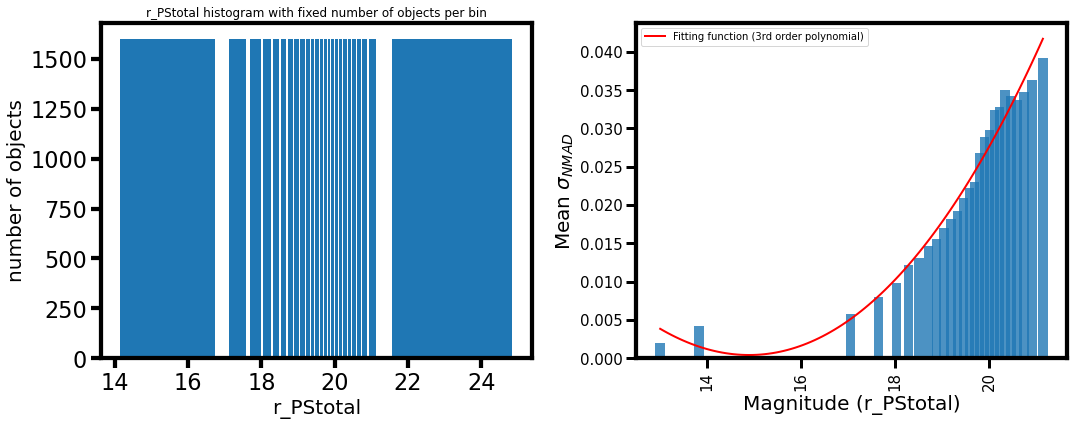

In [3]:
#Another way to do this would be to add an "__init__.py" to the folder '/work/Doc/galaxy-cluster-membership/' and import it as galaxy-cluster-membership.galaxy_cluster_membership I think
#See https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
# import sys
# sys.path.insert(1, '/work/Doc/galaxy-cluster-membership/')
from galaxy_cluster_membership import *

In [4]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc, rcParams
f = 0.8

fontsize = 35 * f
labelsize = 20 * f

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')
cm3 = plt.cm.get_cmap('gnuplot2')

color_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colors1 = [cm1(value) for value in color_values]
colors2 = [cm2(value) for value in color_values]
colors3 = [cm3(value) for value in color_values]

### I have to identify some clusters in this mock in order to apply the membership over them
#### Start from here

In [5]:
hdul = fits.open("cluster-mocks/lightcone_zphot_subhalos_AllFrom1.fits")
scat = hdul[1].data

magr = scat["mag_r"]
mask_mag = magr < 21

haloId = scat["haloId"][mask_mag]
galaxyId = scat["galaxyId"][mask_mag]
z_phot_original = scat["z_phot"][mask_mag]
z_spec = scat["z_app"][mask_mag]
ra = scat["RA"][mask_mag]
dec = scat["DEC"][mask_mag]
magr = scat["mag_r"][mask_mag]
magu = scat["mag_u"][mask_mag]
magg = scat["mag_g"][mask_mag]
magi = scat["mag_i"][mask_mag]
magz = scat["mag_z"][mask_mag]
firstHaloinFoFGroupId = scat["firstHaloinFoFGroupId"][mask_mag]

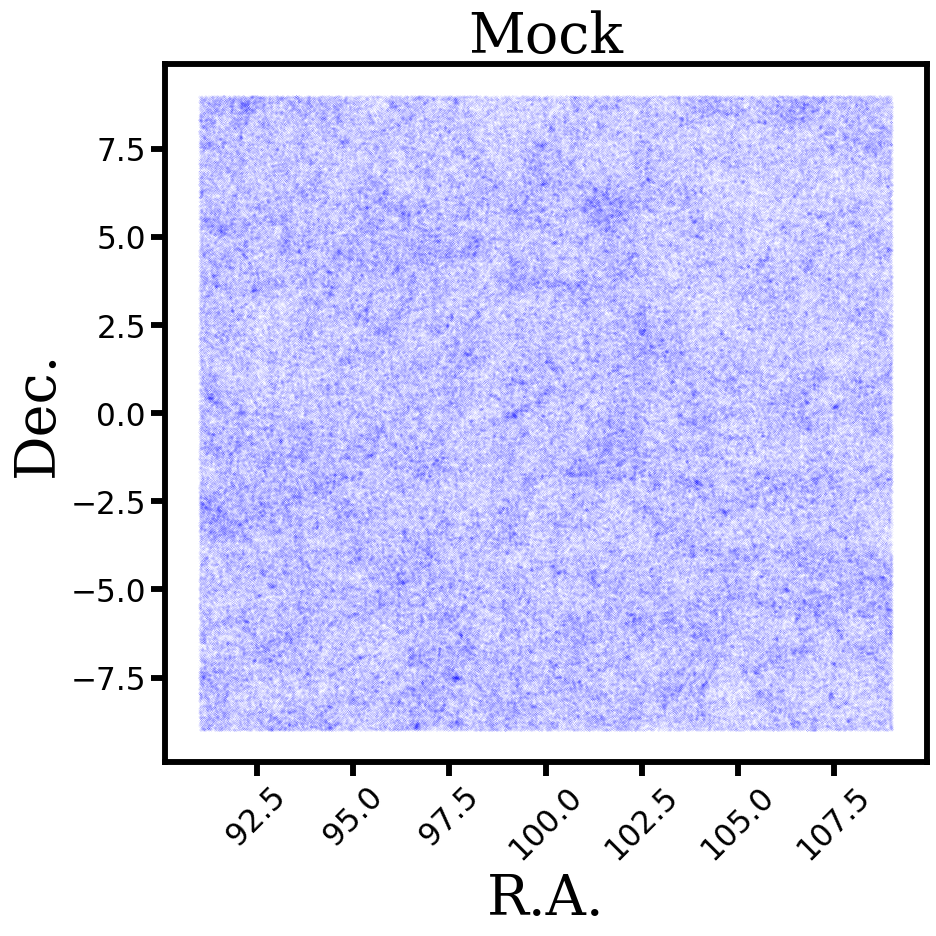

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

sc = ax.scatter(ra, dec, c="blue", s=0.0005)
ax.set_xlabel("R.A.", fontdict=font)
ax.set_ylabel("Dec.", fontdict=font)
ax.set_title("Mock", fontdict=font)

ax.tick_params(axis='x', rotation=45)
    
fig.tight_layout(pad=3.0)

### Dealing with the photo-zs of the mock

There are two issues associated with the photo-zs: <br>
- In the case of the mock, the photo-zs are just single point estimates (SPEs), so that I was having to simulate them as simple gaussians centered on these SPE values. Although, a real photo-z PDF has three associated means, weights and stds, each one for one of the gaussians of the Gaussian Mixture Model used by Erik in his method. Therefore, to associate real PDF attributes to the photo-zs of galaxies in the mock, I will apply a KNN method to find for galaxies in Erik's photo-z training sample with similar properties to the ones in the mock, and then assign the photo-z PDF properties of these real galaxies to them;
- The other issue is that the photo-zs of the galaxies have a small shift (bias) compared to the cluster redshift. It is a good idea to correct for this bias before applying the method.

In [6]:
training_set_pdfs = pd.read_csv("testing_dataset_photoz_pdfs.csv", 
                   usecols=['z_x', 'u_PStotal', 'g_PStotal', 'r_PStotal', 'i_PStotal', 'z_PStotal', 
                           'pdf_weights_0', 'pdf_weights_1', 'pdf_weights_2', 'pdf_means_0', 'pdf_means_1', 
                           'pdf_means_2', 'pdf_stds_0', 'pdf_stds_1', 'pdf_stds_2', 'zml']) 

z_pdfs = training_set_pdfs['z_x']
zp_pdfs = training_set_pdfs['zml']
u_PStotal_pdfs = training_set_pdfs['u_PStotal']
g_PStotal_pdfs = training_set_pdfs['g_PStotal']
r_PStotal_pdfs = training_set_pdfs['r_PStotal']
i_PStotal_pdfs = training_set_pdfs['i_PStotal']
z_PStotal_pdfs = training_set_pdfs['z_PStotal']
weights_0_pdfs = training_set_pdfs['pdf_weights_0']
weights_1_pdfs = training_set_pdfs['pdf_weights_1']
weights_2_pdfs = training_set_pdfs['pdf_weights_2']
means_0_pdfs = training_set_pdfs['pdf_means_0']
means_1_pdfs = training_set_pdfs['pdf_means_1']
means_2_pdfs = training_set_pdfs['pdf_means_2']
stds_0_pdfs = training_set_pdfs['pdf_stds_0']
stds_1_pdfs = training_set_pdfs['pdf_stds_1']
stds_2_pdfs = training_set_pdfs['pdf_stds_2']

In [7]:
# mock_attributes = np.array([z_spec[mask_cluster], magr[mask_cluster]])
# obs_attributes = np.array([z_pdfs[~np.isnan(r_PStotal_pdfs)], r_PStotal_pdfs[~np.isnan(r_PStotal_pdfs)]])

#The idea here is to attribute photo-z pdf properties do galaxies in the mock according to their magnitude bins

# indices = np.array([])
# for m in np.arange(16, 21, 0.5):
#     mag_bin_mock = (magr > m) & (magr < m+0.5)
#     mag_bin_obs = (r_PStotal_pdfs > m) & (r_PStotal_pdfs < m+1)
    
#     mock_attributes = np.array([z_spec[mag_bin_mock]])
#     obs_attributes = np.array([z_pdfs[mag_bin_obs]])

#     nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(obs_attributes.T)

#     d, i = nbrs.kneighbors(mock_attributes.T)
#     indices = np.concatenate((indices, i.T[0]))


mock_attributes = np.array([z_spec])
obs_attributes = np.array([z_pdfs])

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(obs_attributes.T)

d, indices = nbrs.kneighbors(mock_attributes.T)

In [8]:
z_phot_pdfs = np.array([zp_pdfs[i] for i in indices[:, 0]])
weights_0_pdfs_mock = np.array([weights_0_pdfs[i] for i in indices[:, 0]])
weights_1_pdfs_mock = np.array([weights_1_pdfs[i] for i in indices[:, 0]])
weights_2_pdfs_mock = np.array([weights_2_pdfs[i] for i in indices[:, 0]])
means_0_pdfs_mock = np.array([means_0_pdfs[i] for i in indices[:, 0]])
means_1_pdfs_mock = np.array([means_1_pdfs[i] for i in indices[:, 0]])
means_2_pdfs_mock = np.array([means_2_pdfs[i] for i in indices[:, 0]])
stds_0_pdfs_mock = np.array([stds_0_pdfs[i] for i in indices[:, 0]])
stds_1_pdfs_mock = np.array([stds_1_pdfs[i] for i in indices[:, 0]])
stds_2_pdfs_mock = np.array([stds_2_pdfs[i] for i in indices[:, 0]])

# z_phot_pdfs = np.array([zp_pdfs[i] for i in indices])
# weights_0_pdfs_mock = np.array([weights_0_pdfs[i] for i in indices])
# weights_1_pdfs_mock = np.array([weights_1_pdfs[i] for i in indices])
# weights_2_pdfs_mock = np.array([weights_2_pdfs[i] for i in indices])
# means_0_pdfs_mock = np.array([means_0_pdfs[i] for i in indices])
# means_1_pdfs_mock = np.array([means_1_pdfs[i] for i in indices])
# means_2_pdfs_mock = np.array([means_2_pdfs[i] for i in indices])
# stds_0_pdfs_mock = np.array([stds_0_pdfs[i] for i in indices])
# stds_1_pdfs_mock = np.array([stds_1_pdfs[i] for i in indices])
# stds_2_pdfs_mock = np.array([stds_2_pdfs[i] for i in indices])

weights_pdfs_mock = np.vstack((weights_0_pdfs_mock, weights_1_pdfs_mock, weights_2_pdfs_mock))
means_pdfs_mock = np.vstack((means_0_pdfs_mock, means_1_pdfs_mock, means_2_pdfs_mock))
stds_pdfs_mock = np.vstack((stds_0_pdfs_mock, stds_1_pdfs_mock, stds_2_pdfs_mock))

### Let's determine the properties of the 20 most populated clusters of the mock

11
12
13
14
15
16
17
18
19
20


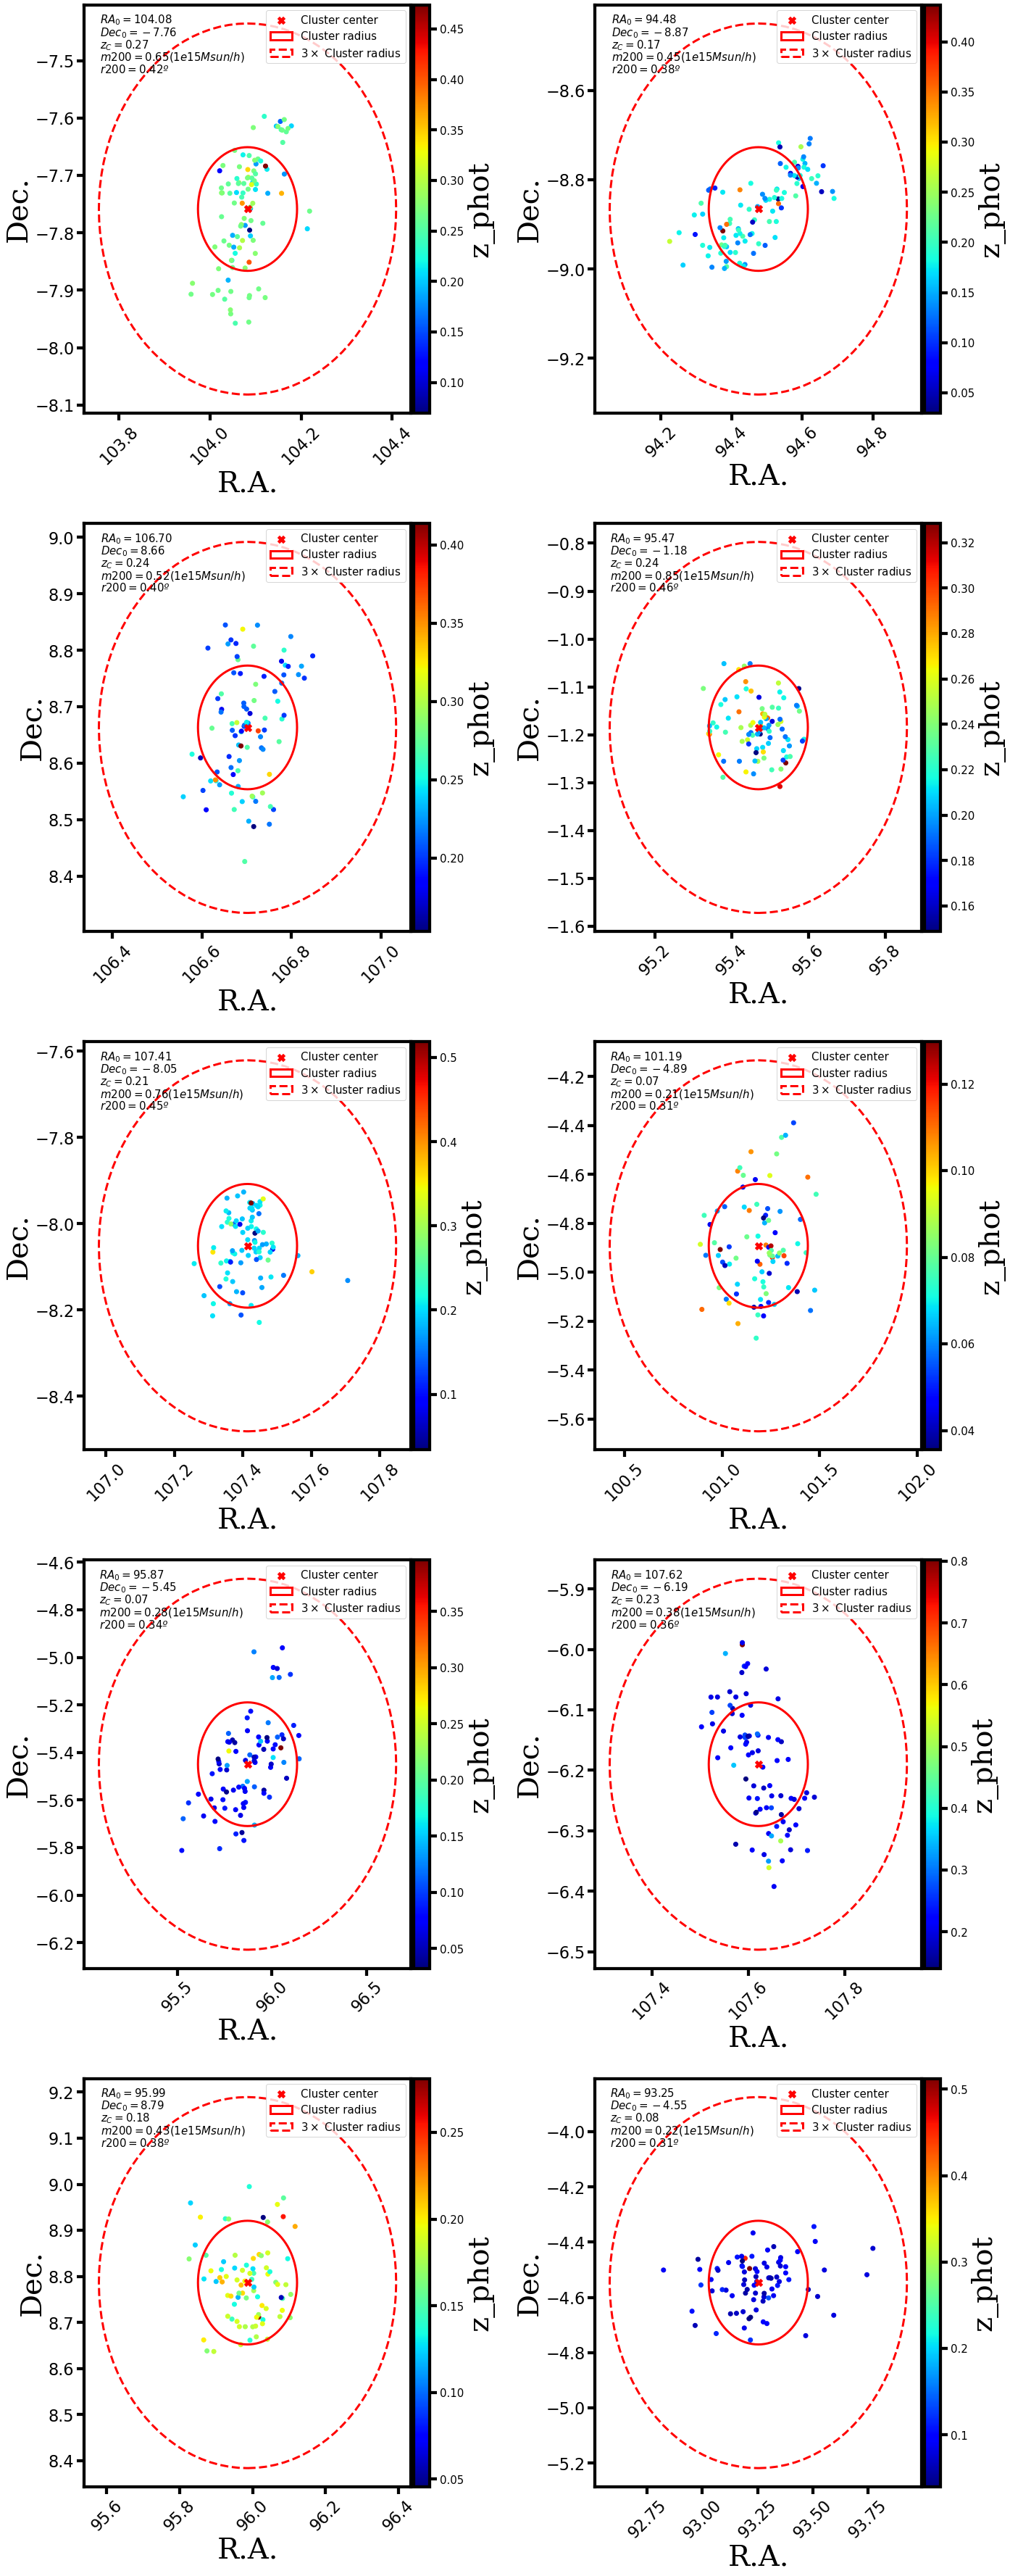

In [158]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 50))

for j in np.arange(11, 21, 1):
    
    print(j)

    halo_id = np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[halo_members_list == np.sort(halo_members_list)[-j]]
    if j == 11: halo_id = halo_id[0]
    if j == 12: halo_id = halo_id[1]
    if j == 13: halo_id = halo_id[0]
    if j == 14: halo_id = halo_id[1]
    if j == 16: halo_id = halo_id[0]
    if j == 17: halo_id = halo_id[1]
    
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]
    
    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)

    z_bins = 30
    i = np.argmax(np.histogram(halo_zspec, bins=z_bins)[0])
    z_cluster = np.histogram(halo_zspec, bins=z_bins)[1][i]
    
    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)
    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)
    
    
    ax1 = axs[int(np.floor((j-11)/2)), (j-11)%2]
    sc = ax1.scatter(halo_ra, halo_dec, c=halo_zphot, cmap=cm1)
    ax1.set_xlabel("R.A.", fontdict=font)
    ax1.set_ylabel("Dec.", fontdict=font)

    ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")

    ax1.tick_params(axis='x', rotation=45)

    c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

    r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
                lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
    ax1.add_patch(r1)

    r2 = SphericalCircle(c0, 3*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
                lw=3, label=r"$3 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
    ax1.add_patch(r2)
    
    ax1.text(ra0-3*r200_deg, dec0+3*r200_deg, s=r"$RA_0 = {:.2f}$".format(ra0), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.8*r200_deg, s=r"$Dec_0 = {:.2f}$".format(dec0), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.6*r200_deg, s=r"$z_C = {:.2f}$".format(z_cluster), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.4*r200_deg, s=r"$m200 = {:.2f} (1e15 Msun/h)$".format(m200.value/1e15), fontsize=15)
    ax1.text(ra0-3*r200_deg, dec0+2.2*r200_deg, s=r"$r200 = {:.2f}º$".format(r200.value), fontsize=15)
    
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
    cbar.set_label(label="z_phot", fontdict=font)
    cbar.ax.tick_params(labelsize=labelsize)

    ax1.legend(fontsize=labelsize)
    
    fig.tight_layout(pad=3.0)

### Defining list of clusters' halo ids

In [9]:
#I have to apply the mask "firstHaloinFoFGroupId > 0" because otherwise I will have the value -9223372036854775808
#in it, which is actually a value assumed by python for the galaxies with no firstHaloinFoFGroupId assigned to it

halo_members_list = []
for i in range(len(np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0]))):
    halo_members = np.sum(firstHaloinFoFGroupId == np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[i])
    halo_members_list.append(halo_members)

halo_ids_list = np.array([])
for i_mock in np.arange(0, 200, 1):
    halo_ids = np.unique(firstHaloinFoFGroupId[firstHaloinFoFGroupId > 0])[halo_members_list == np.flip(np.sort(halo_members_list))[i_mock]]
    halo_ids_list = np.concatenate((halo_ids_list, halo_ids))

halo_ids_list_unique = []
for h in halo_ids_list:
    if ~np.isin(h, halo_ids_list_unique): halo_ids_list_unique.append(h)


## Running in a loop

In [11]:
table = Table(scat)

for i_mock in np.arange(0, 100):
    
    halo_id = halo_ids_list_unique[i_mock]
    halo_mask = firstHaloinFoFGroupId == halo_id

    halo_ra = ra[halo_mask]
    halo_dec = dec[halo_mask]
    halo_zphot = z_phot_pdfs[halo_mask]
    halo_zspec = z_spec[halo_mask]
    halo_magr = magr[halo_mask]

    #Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
    ra0 = np.mean(halo_ra)
    dec0 = np.mean(halo_dec)
    
    z_bins = 20
    bw = (halo_zspec.max() - halo_zspec.min()) / z_bins

    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
    zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
    log_dens_zz = kde.score_samples(zz)

    z_cluster = zz[np.argmax(np.exp(log_dens_zz))]
    
    m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h
    r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
    r200_mpc = r200.to(u.Mpc)

    kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
    r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

    pre_mask = (ra < ra0 + 6*r200_deg) & (ra > ra0 - 6*r200_deg) & (dec < dec0 + 6*r200_deg) & (dec > dec0 - 6*r200_deg)
    halo_mask_restricted = halo_mask[pre_mask]

    dist = clustercentric_distance(ra[pre_mask], dec[pre_mask], ra0, dec0)
    
    dist_field = dist[~halo_mask_restricted]
    
    sigma_z = np.array([sigma_nmad_(r) for r in magr[pre_mask]])

    #Define the volume of the cluster
    #fz1 determines the extent of the "mask_cluster", fz2 determines the extent to compute P(C | zp), and fr defines the radial extent of the objects
    fz1 = 1.0
    fz2 = fz1
    fr = 5.0

    #This mask defines all galaxies in the fr*R200 projected area of the cluster
    mask_cluster_region = dist < fr*r200_deg

    #This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
    mask_cluster = mask_cluster_region & (z_phot_pdfs[pre_mask] > z_cluster - fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs[pre_mask] < z_cluster + fz1*sigma_z*(1+z_cluster))
    
    bw = (z_phot_pdfs[pre_mask][mask_cluster].max() - z_phot_pdfs[pre_mask][mask_cluster].min()) / z_bins

    kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(z_phot_pdfs[pre_mask][mask_cluster][:, np.newaxis])
    zz_phot = np.linspace(z_phot_pdfs[pre_mask][mask_cluster].min(), z_phot_pdfs[pre_mask][mask_cluster].max(), 
                          len(z_phot_pdfs[pre_mask][mask_cluster]))[:, np.newaxis]
    log_dens_zz_phot = kde.score_samples(zz_phot)

    zp_peak = zz_phot[np.argmax(np.exp(log_dens_zz_phot))]
    zp_bias = zp_peak - z_cluster

    z_phot_pdfs_unbiased = z_phot_pdfs - zp_bias

    mask_cluster_unbiased = mask_cluster_region & (z_phot_pdfs_unbiased[pre_mask] > z_cluster - 
                        fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs_unbiased[pre_mask] < z_cluster + fz1*sigma_z*(1+z_cluster))

    halo_zphot = z_phot_pdfs_unbiased[halo_mask]
    
    P_pz_C_array = P_pz_v2(z_cluster, magr[pre_mask][mask_cluster_unbiased],
                       means_pdfs_mock.T[pre_mask][mask_cluster_unbiased], 
                       weights_pdfs_mock.T[pre_mask][mask_cluster_unbiased],
                       stds_pdfs_mock.T[pre_mask][mask_cluster_unbiased], fz=3.0)
    
    mask_infalling = spec_members_vesc(m200, r200_mpc/cosmo.h, z_cluster, z_spec[pre_mask][mask_cluster_unbiased], 1.0)
    z_infalling = z_spec[pre_mask][mask_cluster_unbiased][mask_infalling]

    
    completeness_zp = []
    purity_zp = []
    d = 0.01
    Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

    for Pmem_cut in Pmem_cut_arr_zp:

        c = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(mask_infalling)
        p = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(P_pz_C_array > Pmem_cut)

        completeness_zp.append(c)
        purity_zp.append(p)
        
    #We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
    completeness_zp = np.array(completeness_zp)
    purity_zp = np.array(purity_zp)

    F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)

    cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

    table[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp].write("tables/testing-on-mocks/cluster-mock_{}_members.csv".format(i_mock), format='csv', overwrite=True)

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/g

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:311: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), 0.0, zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membershi

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:311: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), 0.0, zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:311: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), 0.0, zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: Integ

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarni

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galax

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarni

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:311: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), 0.0, zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membershi

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarni

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:311: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), 0.0, zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membershi

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  P_pz_C = integrate.quad(lambda x: pdf_func(x), zc - fz*sigma_i*(1+zc), zc + fz*sigma_i*(1+zc))[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:314: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

## Not a loop anymore

In [195]:
#To select the five more populated halos, I just need to do the following for the 
#last five elements of np.sort(halo_members_list)

#I am selecting the haloId of the cluster with the higher number of elements
#To select the five most populated cluster, I just need to apply i = 1, 2, 3, 4, 5

i_mock = 25
halo_id = halo_ids_list_unique[i_mock]
halo_mask = firstHaloinFoFGroupId == halo_id

halo_ra = ra[halo_mask]
halo_dec = dec[halo_mask]
halo_zphot = z_phot_pdfs[halo_mask]
halo_zspec = z_spec[halo_mask]
halo_magr = magr[halo_mask]

#Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
ra0 = np.mean(halo_ra)
dec0 = np.mean(halo_dec)

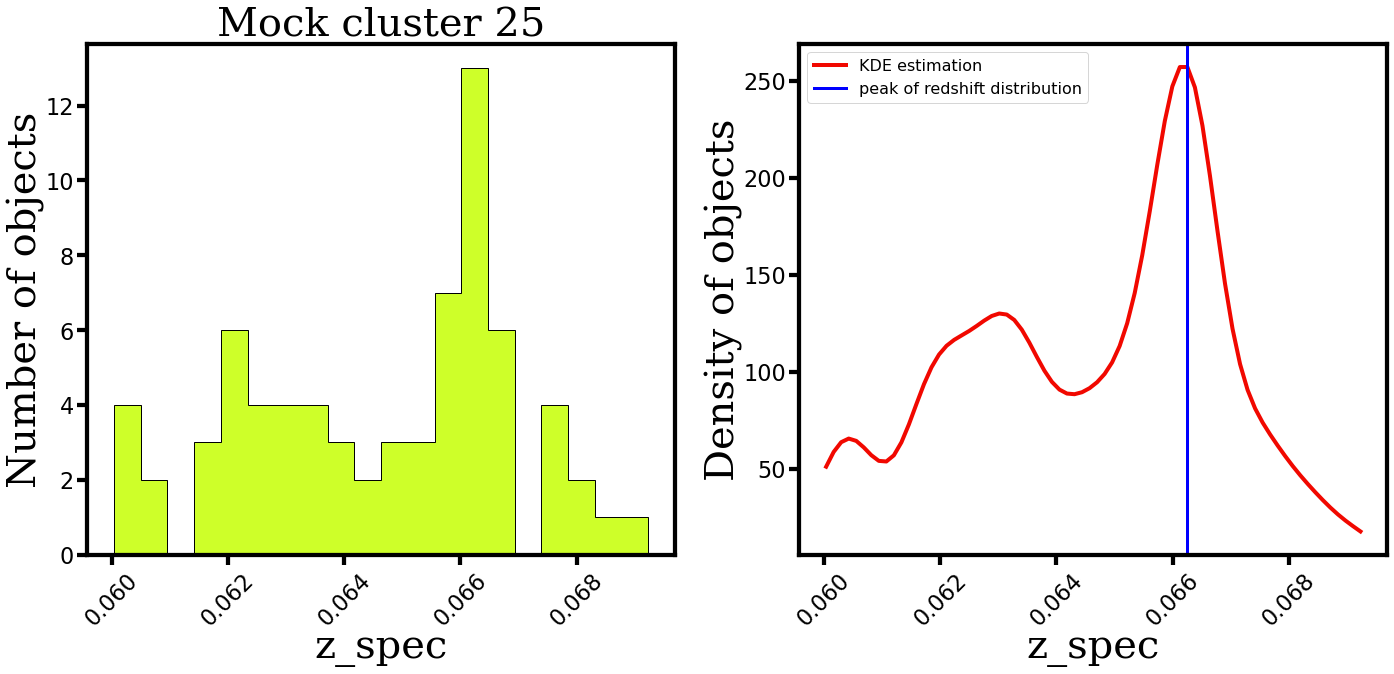

In [196]:
z_bins = 20
bw = (halo_zspec.max() - halo_zspec.min()) / z_bins

kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
log_dens_zz = kde.score_samples(zz)

z_cluster = zz[np.argmax(np.exp(log_dens_zz))]


fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(halo_zspec, bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k', 
         range=[halo_zspec.min(), halo_zspec.max()])[2]

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel("z_spec", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.tick_params(axis='x', rotation=45)

ax2 = fig.add_subplot(122)
ax2.plot(zz, np.exp(log_dens_zz), lw=4, color=colors1[8], label="KDE estimation")
ax2.axvline(z_cluster, color="blue", lw=3, label="peak of redshift distribution")
ax2.set_xlabel("z_spec", fontdict=font)
ax2.set_ylabel("Density of objects", fontdict=font)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=labelsize)


fig.tight_layout(pad=3.0)

plt.savefig("../figures/membership-testing-on-mocks/z_distribution_mock{}.png".format(i_mock), dpi='figure', format='png')

In [197]:
m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h

r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
r200_mpc = r200.to(u.Mpc)

kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)

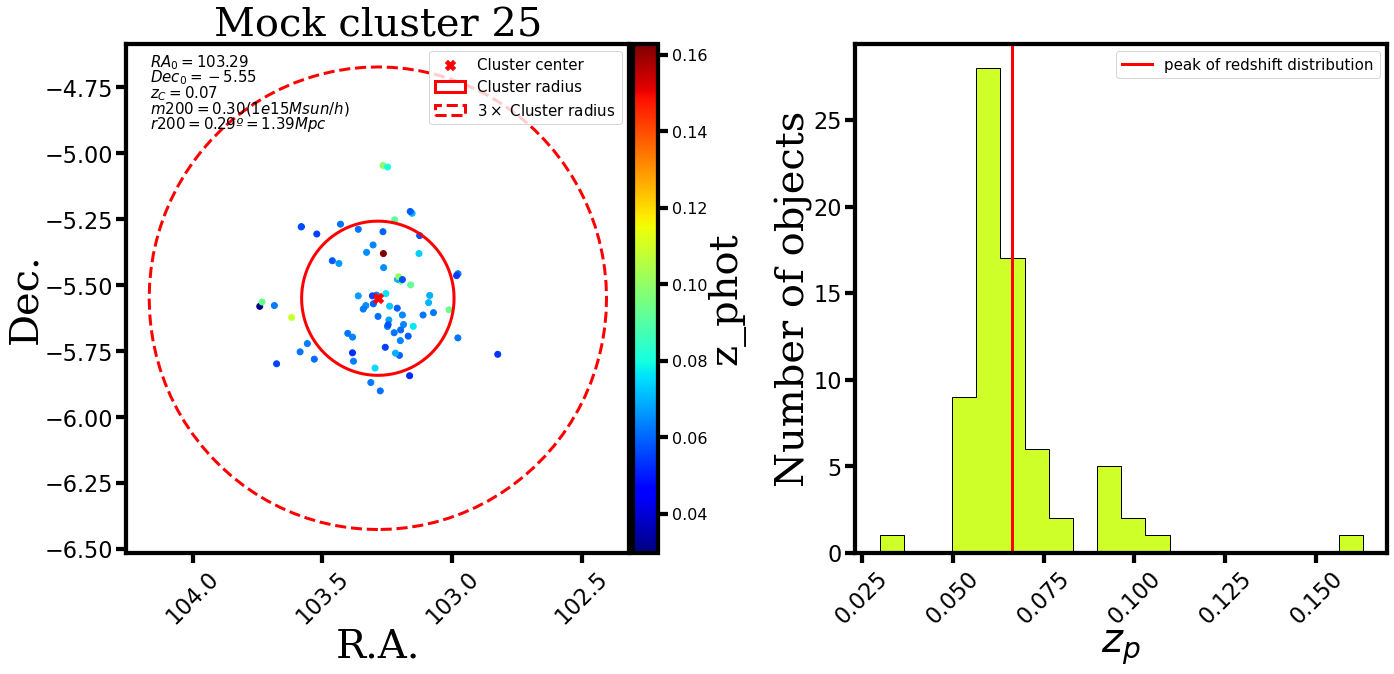

In [198]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(121)
sc = ax1.scatter(halo_ra, halo_dec, c=halo_zphot, cmap=cm1)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel("R.A.", fontdict=font)
ax1.set_ylabel("Dec.", fontdict=font)
ax1.tick_params(axis='x', rotation=45)

ax1.text(ra0+3*r200_deg, dec0+3*r200_deg, s=r"$RA_0 = {:.2f}$".format(ra0), fontsize=15)
ax1.text(ra0+3*r200_deg, dec0+2.8*r200_deg, s=r"$Dec_0 = {:.2f}$".format(dec0), fontsize=15)
ax1.text(ra0+3*r200_deg, dec0+2.6*r200_deg, s=r"$z_C = {:.2f}$".format(z_cluster[0]), fontsize=15)
ax1.text(ra0+3*r200_deg, dec0+2.4*r200_deg, s=r"$m200 = {:.2f} (1e15 Msun/h)$".format(m200.value/1e15), fontsize=15)
ax1.text(ra0+3*r200_deg, dec0+2.2*r200_deg, s=r"$r200 = {:.2f}º = {:.2f} Mpc$".format(r200_deg[0], r200_mpc.value[0]), fontsize=15)
# ax1.text(ra0-3*r200_deg, dec0+2.0*r200_deg, s=r"$r200 = {:.2f} Mpc$".format(r200_mpc.value[0]), fontsize=15)

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r2 = SphericalCircle(c0, 3*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$3 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r2)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="z_phot", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.invert_xaxis()

ax1.legend(fontsize=15)


ax3 = fig.add_subplot(122)
ax3.hist(halo_zphot, bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k')[2]
ax3.set_xlabel(r"$z_p$", fontdict=font)
ax3.set_ylabel("Number of objects", fontdict=font)
# ax3.axvline(mean_z, color="red", lw=3, label="mean redshift")
# ax3.axvline(median_z, color="brown", lw=3, label="median redshift")
ax3.axvline(z_cluster, color="red", lw=3, label="peak of redshift distribution")
ax3.tick_params(axis='x', rotation=45)
ax3.legend(fontsize=15)
    
fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/RA_DEC_z_zphot(KNN-with-z)_distribution_mock{}.png".format(i_mock), dpi='figure', format='png')

I just defined the center and the redshift of the cluster, i.e., the center is given by mean of RA and DEC positions of galaxies in the clister (halo), and the redshift is the mean value of spectroscopic redshifts of galaxies in the cluster (maybe we could consider the median, but it it very similar to the mean). <br>

Next step is to get all field galaxies in the region of the cluster. I am thinking of doing it by considering a circular region of the cluster with a radius equals to the larger distance between a galaxy in the cluster an the center of the cluster. Then the field galaxies will be all galaxies distancing less than this radius from the center of the cluster.

In [199]:
pre_mask = (ra < ra0 + 6*r200_deg) & (ra > ra0 - 6*r200_deg) & (dec < dec0 + 6*r200_deg) & (dec > dec0 - 6*r200_deg)
halo_mask_restricted = halo_mask[pre_mask]

dist = clustercentric_distance(ra[pre_mask], dec[pre_mask], ra0, dec0)

In [200]:
#Computing the distance between all galaxies that I know are not in the cluster and the center of the cluster
# dist_field = clustercentric_distance(ra[~halo_mask], dec[~halo_mask], ra0, dec0)
dist_field = dist[~halo_mask_restricted]

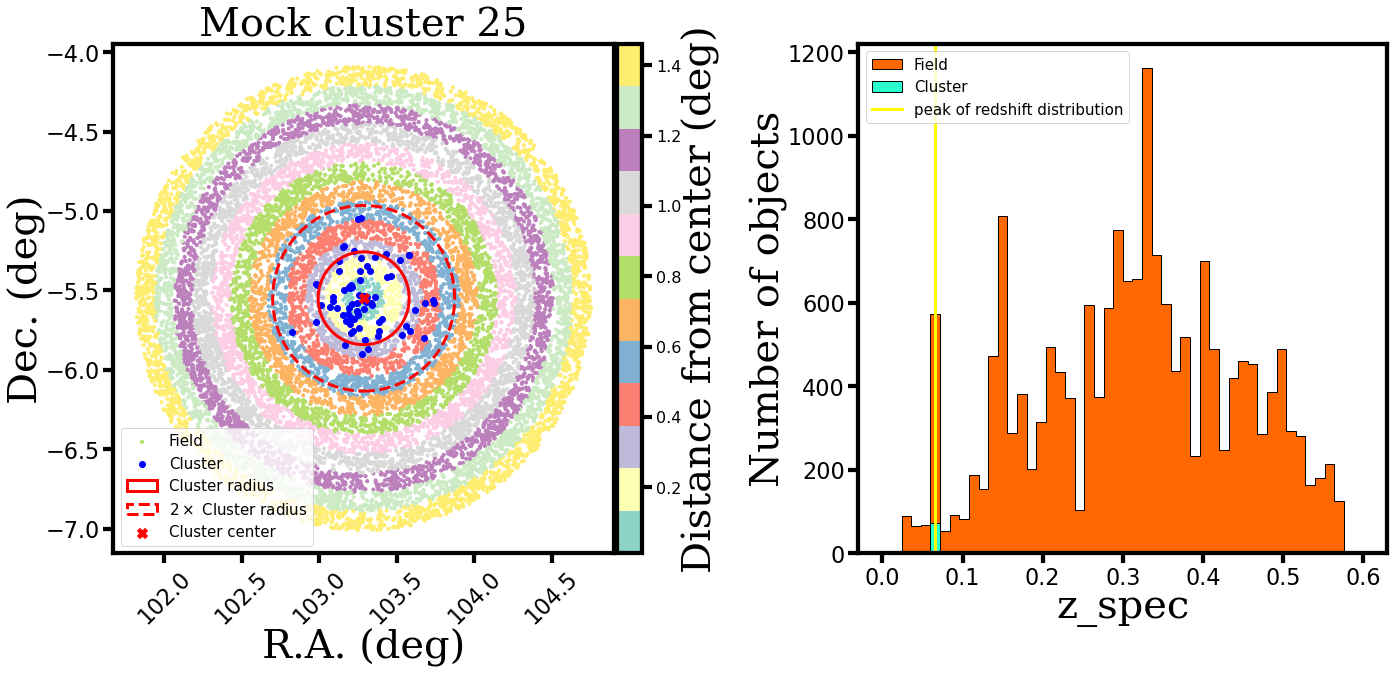

In [201]:
fig = plt.figure(figsize=(20, 10))


ax1 = fig.add_subplot(121)
max_dist = 5*r200_deg
sc = ax1.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c=dist_field[dist_field < max_dist], cmap=cm.Set3, s=10, label="Field")

sc2 = ax1.scatter(halo_ra, halo_dec, c="blue", label="Cluster")

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r2 = SphericalCircle(c0, 2*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$2 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r2)

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)

ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")

ax1.tick_params(axis='x', rotation=45)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax1, orientation='vertical')
cbar.set_label(label="Distance from center (deg)", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.legend(fontsize=15)



max_z = 0.6
ax2 = fig.add_subplot(122)

ax2.hist(z_spec[pre_mask][~halo_mask_restricted][dist_field < max_dist], bins=50, 
        color=colors1[7], histtype='stepfilled', edgecolor='k', range=[0, max_z], label="Field")[2]

ax2.hist(halo_zspec, bins=50, color=colors1[3], histtype='stepfilled', edgecolor='k',
        range=[0, max_z], label="Cluster")[2]

ax2.set_xlabel("z_spec", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)

# ax2.axvline(mean_z, color="red", lw=2, label="mean redshift")
# ax2.axvline(median_z, color="yellow", lw=2, label="median redshift")
ax2.axvline(z_cluster, color="yellow", lw=3, label="peak of redshift distribution")
ax2.legend(fontsize=15, loc=2)

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/RA_DEC_z_distribution_field&cluster_mock{}.png".format(i_mock), dpi='figure', format='png')

### Definining a volume for the cluster and removing bias from photo-zs


In [202]:
sigma_z = np.array([sigma_nmad_(r) for r in magr[pre_mask]])

#Define the volume of the cluster
#fz1 determines the extent of the "mask_cluster", fz2 determines the extent to compute P(C | zp), and fr defines the radial extent of the objects
fz1 = 1.0
fz2 = fz1
fr = 5.0

#This mask defines all galaxies in the fr*R200 projected area of the cluster
mask_cluster_region = dist < fr*r200_deg

#This one restricts the above mask to only the galaxies delimited by +/-fz*sigma from the cluster redshift, defining a list of candidate members
mask_cluster = mask_cluster_region & (z_phot_pdfs[pre_mask] > z_cluster - fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs[pre_mask] < z_cluster + fz1*sigma_z*(1+z_cluster))

In [203]:
bw = (z_phot_pdfs[pre_mask][mask_cluster].max() - z_phot_pdfs[pre_mask][mask_cluster].min()) / z_bins

kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(z_phot_pdfs[pre_mask][mask_cluster][:, np.newaxis])
zz_phot = np.linspace(z_phot_pdfs[pre_mask][mask_cluster].min(), z_phot_pdfs[pre_mask][mask_cluster].max(), 
                      len(z_phot_pdfs[pre_mask][mask_cluster]))[:, np.newaxis]
log_dens_zz_phot = kde.score_samples(zz_phot)

zp_peak = zz_phot[np.argmax(np.exp(log_dens_zz_phot))]
zp_bias = zp_peak - z_cluster

z_phot_pdfs_unbiased = z_phot_pdfs - zp_bias

mask_cluster_unbiased = mask_cluster_region & (z_phot_pdfs_unbiased[pre_mask] > z_cluster - 
                    fz1*sigma_z*(1+z_cluster)) & (z_phot_pdfs_unbiased[pre_mask] < z_cluster + fz1*sigma_z*(1+z_cluster))

halo_zphot = z_phot_pdfs_unbiased[halo_mask]

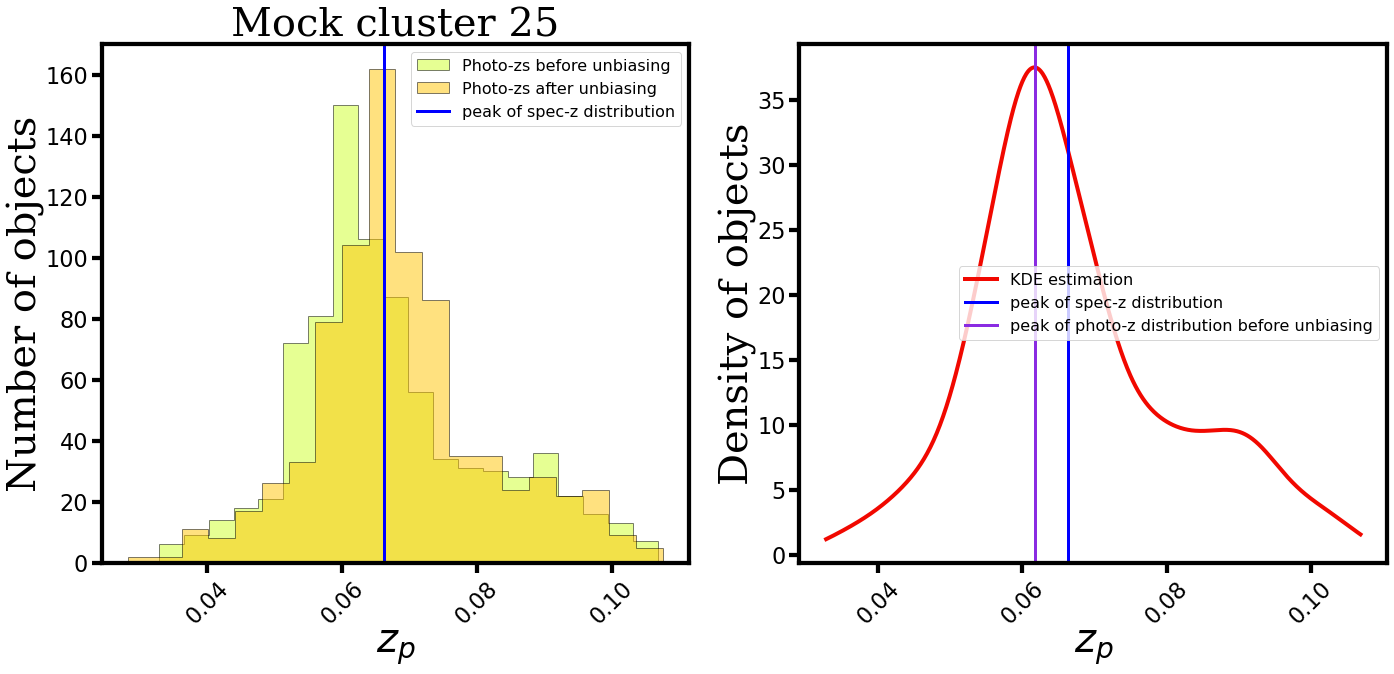

In [204]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121)
ax1.hist(z_phot_pdfs[pre_mask][mask_cluster], bins=z_bins, color=colors1[5], histtype='stepfilled', edgecolor='k', 
         range=[z_phot_pdfs[pre_mask][mask_cluster].min(), z_phot_pdfs[pre_mask][mask_cluster].max()], alpha=0.5, label="Photo-zs before unbiasing")[2]
ax1.hist(z_phot_pdfs_unbiased[pre_mask][mask_cluster_unbiased], bins=z_bins, color=colors1[6], histtype='stepfilled', edgecolor='k', 
         range=[z_phot_pdfs_unbiased[pre_mask][mask_cluster_unbiased].min(), z_phot_pdfs_unbiased[pre_mask][mask_cluster_unbiased].max()], label="Photo-zs after unbiasing", alpha=0.5)[2]
ax1.axvline(z_cluster, color="blue", lw=3, label="peak of spec-z distribution")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel(r"$z_p$", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(fontsize=labelsize)

ax2 = fig.add_subplot(122)
ax2.plot(zz_phot, np.exp(log_dens_zz_phot), lw=4, color=colors1[8], label="KDE estimation")
ax2.axvline(z_cluster, color="blue", lw=3, label="peak of spec-z distribution")
ax2.axvline(zp_peak, color="blueviolet", lw=3, label="peak of photo-z distribution before unbiasing")
ax2.set_xlabel(r"$z_p$", fontdict=font)
ax2.set_ylabel("Density of objects", fontdict=font)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=labelsize)


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/membership-testing-on-mocks/zphot_biased_unbiased_mock{}.png".format(i_mock), dpi='figure', format='png')

### Compute P(C | zp)

To estimate completeness and purity for P(C | zp), I will define the true cluster members + infalling galaxies as the ones selected via 3-sigma-clipping on the spectroscopic redshifts

In [205]:
# P_pz_C_array = P_pz_v2_mock(z_cluster, z_phot_pdfs, magr[mask_cluster], fz=fz2)

P_pz_C_array = P_pz_v2(z_cluster, magr[pre_mask][mask_cluster_unbiased],
                       means_pdfs_mock.T[pre_mask][mask_cluster_unbiased], 
                       weights_pdfs_mock.T[pre_mask][mask_cluster_unbiased],
                       stds_pdfs_mock.T[pre_mask][mask_cluster_unbiased], fz=3.0)

/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:307: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/work/Doc/galaxy-cluster-membership/galaxy_cluster_membership.py:311: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interv

### Selecting spectroscopic members and infalling galaxies to compute purity and completeness

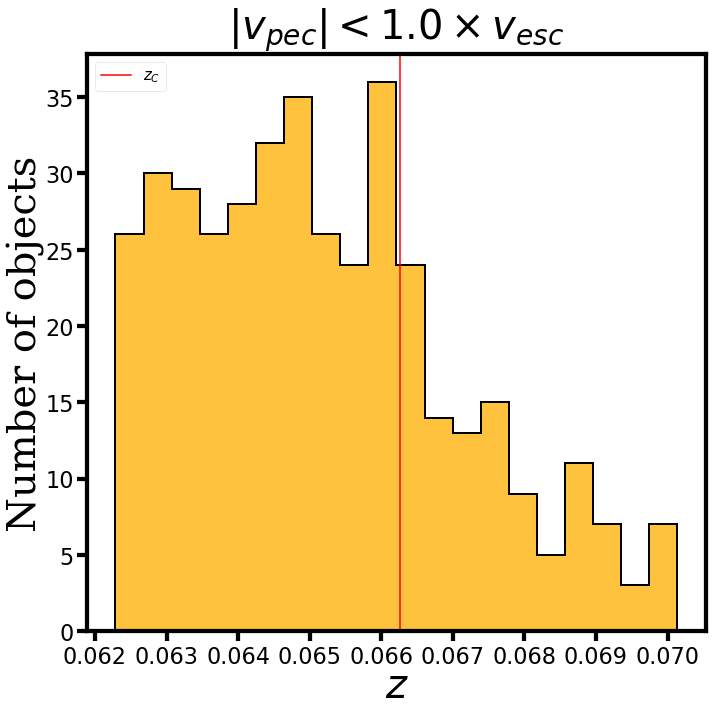

In [206]:
mask_infalling = spec_members_vesc(m200, r200_mpc/cosmo.h, z_cluster, z_spec[pre_mask][mask_cluster_unbiased], 1.0)
z_infalling = z_spec[pre_mask][mask_cluster_unbiased][mask_infalling]

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1.hist(z_infalling, bins=z_bins, histtype='stepfilled', color=colors3[7], alpha=1.0, edgecolor="black", linewidth=2.0)
ax1.set_title(r"$|v_{pec}| < 1.0 \times v_{esc}$", fontdict=font)

ax1.axvline(z_cluster, color="red", label=r"$z_C$")

ax1.set_xlabel(r"$z$", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)

fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/spec_members_mock{}.png".format(i_mock), dpi='figure', format='png')

In [207]:
completeness_zp = []
purity_zp = []
d = 0.01
Pmem_cut_arr_zp = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_zp:
    
    c = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(mask_infalling)
    p = np.sum((P_pz_C_array > Pmem_cut) & mask_infalling) / np.sum(P_pz_C_array > Pmem_cut)
    
    completeness_zp.append(c)
    purity_zp.append(p)

In [208]:
#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_zp = np.array(completeness_zp)
purity_zp = np.array(purity_zp)

F1_zp = 2 * completeness_zp*purity_zp/(completeness_zp + purity_zp)

cut_zp = Pmem_cut_arr_zp[np.argmax(F1_zp)]

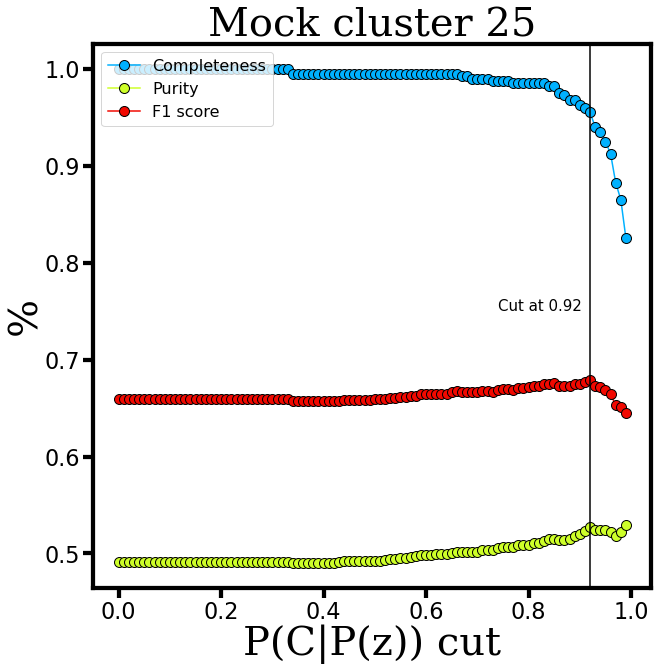

In [209]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_zp, F1_zp, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C|P(z)) cut", fontdict=font)

ax1.axvline(cut_zp, color="black")
ax1.text(x=cut_zp-0.18, y=0.75, s="Cut at {:.2f}".format(cut_zp), fontsize=15)

# c_best = 1.0
# ax1.axhline(c_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

# p_best = 0.82
# ax1.axhline(p_best, color="black", linestyle="dashed")
# ax1.text(0.65, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

ax1.legend(fontsize=labelsize, loc=2)

# plt.savefig("../figures/membership-testing-on-mocks/purity-completeness_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

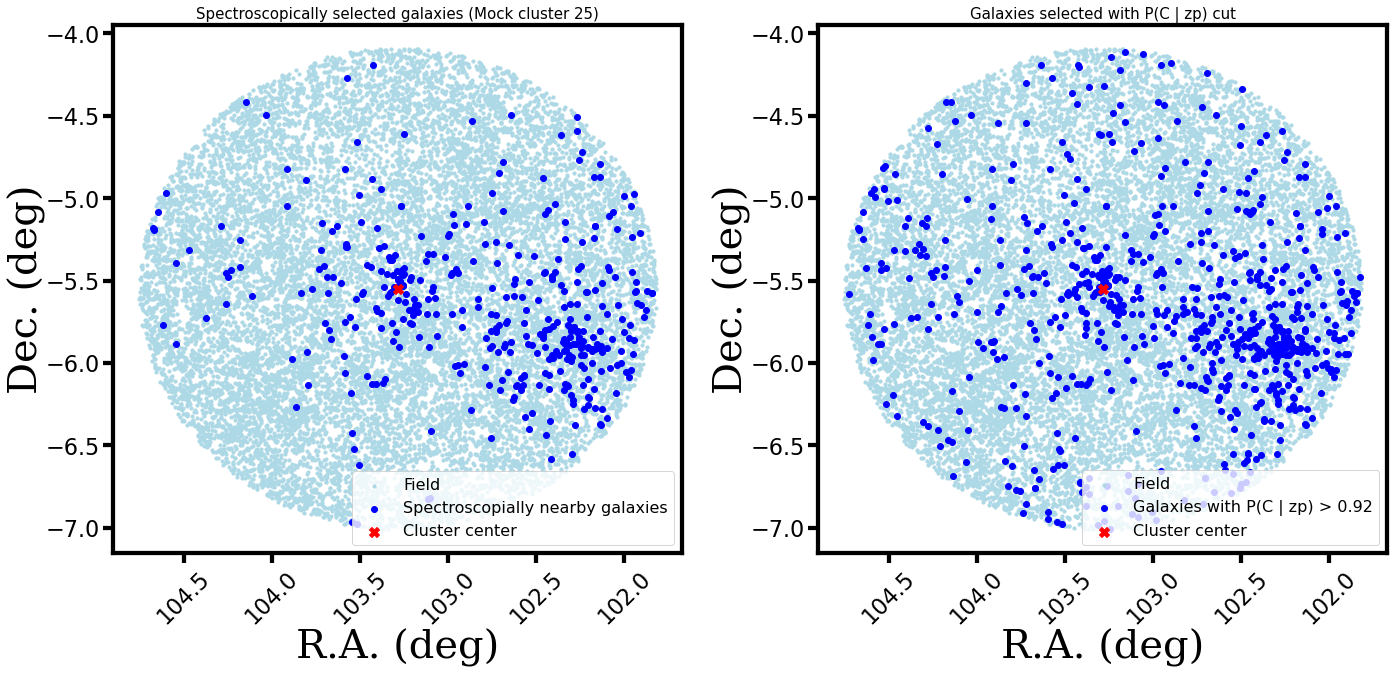

In [210]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax1.scatter(ra[pre_mask][mask_cluster_unbiased][mask_infalling], dec[pre_mask][mask_cluster_unbiased][mask_infalling], c="blue", label="Spectroscopially nearby galaxies")
ax1.set_title("Spectroscopically selected galaxies (Mock cluster {:d})".format(i_mock), fontsize=15)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=labelsize)
ax1.tick_params(axis='x', rotation=45)
ax1.invert_xaxis()

ax2.scatter(ra[pre_mask][~halo_mask_restricted][dist_field < max_dist], dec[pre_mask][~halo_mask_restricted][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax2.scatter(ra[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], dec[pre_mask][mask_cluster_unbiased][P_pz_C_array > cut_zp], c="blue", 
                label="Galaxies with P(C | zp) > {:.2f}".format(cut_zp))
ax2.set_title("Galaxies selected with P(C | zp) cut", fontsize=15)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.legend(fontsize=labelsize)
ax2.tick_params(axis='x', rotation=45)
ax2.invert_xaxis()

    
fig.tight_layout(pad=3.0)


# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|zp)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

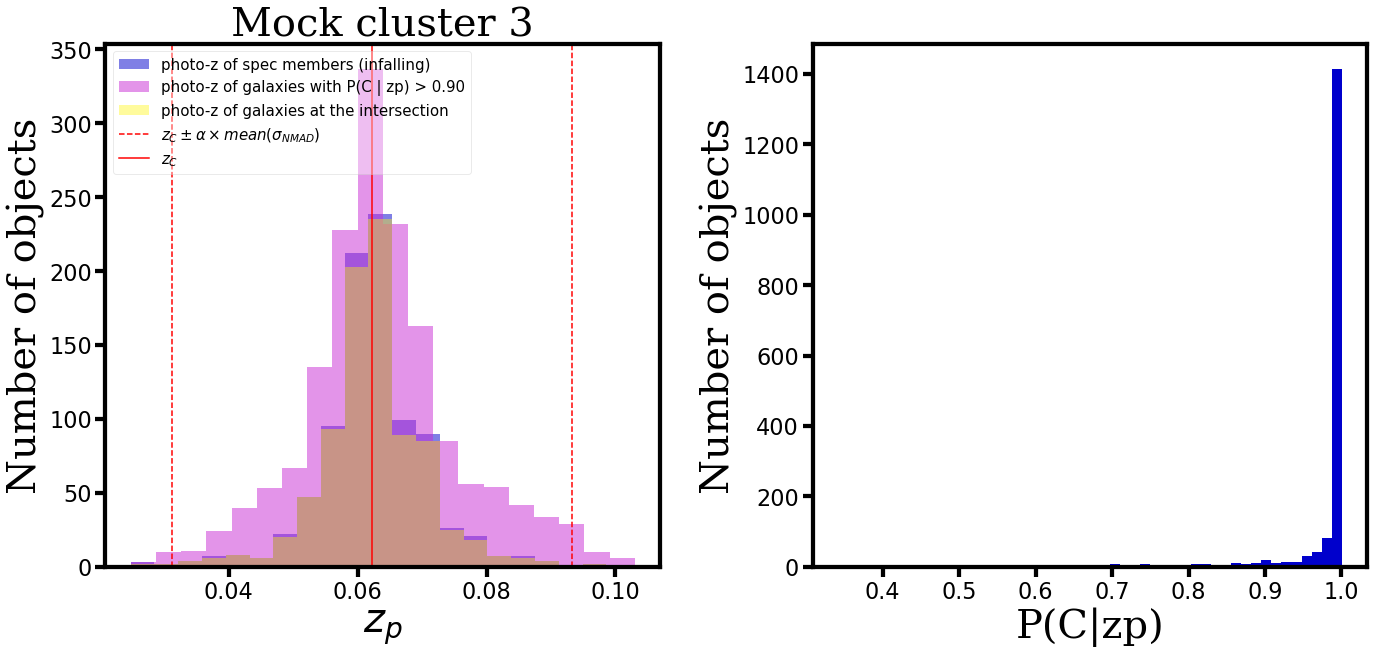

In [34]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(z_phot_pdfs_unbiased[mask_cluster_unbiased][mask_infalling], bins=z_bins, histtype='stepfilled', 
         color=colors3[1], alpha=0.5, label="photo-z of spec members (infalling)")
ax1.hist(z_phot_pdfs_unbiased[mask_cluster_unbiased][P_pz_C_array > cut_zp], bins=z_bins, histtype='stepfilled', 
         color=colors3[4], alpha=0.5, label="photo-z of galaxies with P(C | zp) > {:.2f}".format(cut_zp))
ax1.hist(z_phot_pdfs_unbiased[mask_cluster_unbiased][(P_pz_C_array > cut_zp) & mask_infalling], bins=z_bins, histtype='stepfilled', 
         color=colors3[8], alpha=0.4, label="photo-z of galaxies at the intersection")

ax1.axvline(z_cluster - fz1*np.mean(sigma_z)*(1+z_cluster), color="red", ls='--')
ax1.axvline(z_cluster + fz1*np.mean(sigma_z)*(1+z_cluster), color="red", ls='--', label=r"$z_C \pm \alpha \times mean(\sigma_{NMAD})$")
ax1.axvline(z_cluster, color="red", label=r"$z_C$")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel(r"$z_p$", fontdict=font)
ax1.set_ylabel("Number of objects", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)


bins = 50
ax2.hist(P_pz_C_array, bins=bins, histtype='stepfilled', 
         color=colors3[1], alpha=1.0)
ax2.set_xlabel("P(C|zp)", fontdict=font)
ax2.set_ylabel("Number of objects", fontdict=font)

fig.tight_layout(pad=4.0)

# plt.savefig("../figures/membership-testing-on-mocks/zp_and_probability_distribution_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

### Comparing the selection using $\sigma_{NMAD}$ cut with the probabilistic method (using photo-z PDFs)

In [223]:
completeness_alpha = []
purity_alpha = []

fz_array = np.arange(1.0, 5.5, 0.5)

for fz in fz_array:
    mask_cluster = mask_cluster_region & (z_phot > z_cluster - fz*sigma_z*(1+z_cluster)) & (z_phot < z_cluster + fz*sigma_z*(1+z_cluster))
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster], galaxyId[halo_mask])) / len(galaxyId[mask_cluster])
    
    completeness_alpha.append(c)
    purity_alpha.append(p)

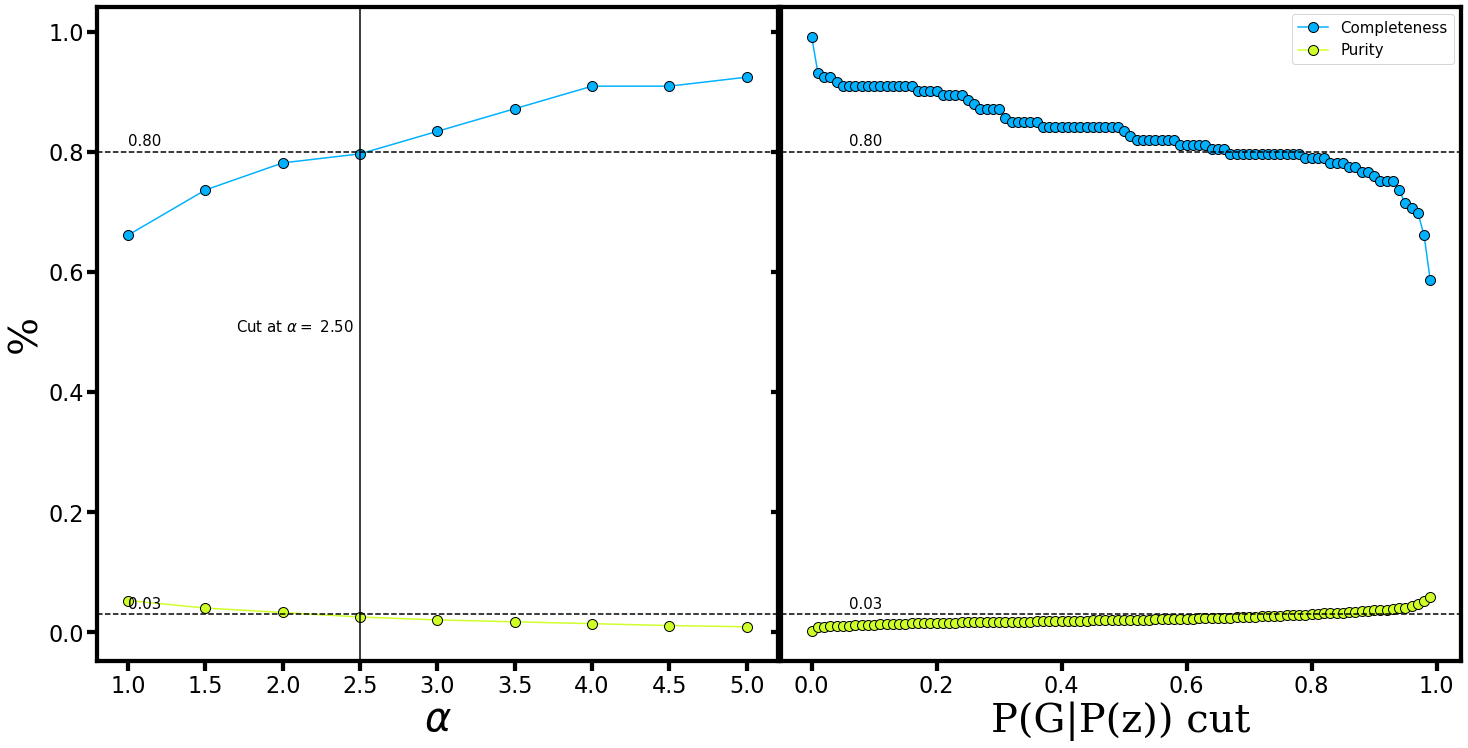

In [233]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
ms = 10

ax1 = axs[0]
ax1.plot(fz_array, completeness_alpha, marker='o', color=colors1[2],label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(fz_array, purity_alpha, marker='o', color=colors1[5], label="Purity", markersize=ms, markeredgecolor="black")
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel(r"$\alpha$", fontdict=font)

c_best = 0.80
ax1.axhline(c_best, color="black", linestyle="dashed")
ax1.text(1.0, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

p_best = 0.03
ax1.axhline(p_best, color="black", linestyle="dashed")
ax1.text(1.0, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)

cut_alpha = 2.5
ax1.axvline(cut_alpha, color="black")
ax1.text(x=cut_alpha-0.8, y=0.5, s=r"Cut at $\alpha =$ {:.2f}".format(cut_alpha), fontsize=15)


ax2 = axs[1]
ax2.plot(Pmem_cut_arr_zp, completeness_zp, marker='o', color=colors1[2], label="Completeness", markersize=ms, markeredgecolor="black")
ax2.plot(Pmem_cut_arr_zp, purity_zp, marker='o', color=colors1[5], label="Purity", markersize=ms, markeredgecolor="black")
ax2.set_xlabel("P(G|P(z)) cut", fontdict=font)
ax2.legend(fontsize=labelsize, loc=1)

# cut = 0.22
# ax2.axvline(cut, color="black")
# ax2.text(x=cut-0.26, y=0.5, s=r"Cut at $P(C|z_p) =$ {:.2f}".format(cut), fontsize=15)

ax2.axhline(c_best, color="black", linestyle="dashed")
ax2.text(0.06, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

ax2.axhline(p_best, color="black", linestyle="dashed")
ax2.text(0.06, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)


fig.tight_layout(pad=-0.7)

## Elliptical surface density profile

In [246]:
#Possible density profiles

def Sigma_NFW_(x, y, rho_s, r_s, q, theta):
    
    theta = np.deg2rad(theta)
    
    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2) / r_s
        
    #where(condition, x(if condition is True), y(if condition is False))    
    f_gt1 = np.where(r > 1, 1 - 2/np.sqrt(r**2 - 1) * np.arctan(np.sqrt((r - 1)/(r + 1))), 0)
    f_lt1 = np.where(r < 1, 1 - 2/np.sqrt(1 - r**2) * np.arctanh(np.sqrt((1 - r)/(1 + r))), 0)
    f_eq1 = np.where(r == 1, 0, 0)
    
    f = f_gt1 + f_lt1 + f_eq1
    
    return 2 * rho_s * r_s * f/ (r**2 - 1)


def Sersic_profile_(x, y, Sigma0, re, n, q, theta):
    '''
    theta: inclination of the ellipse (radians)
    '''

    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2)
    
    #Approximation by Graham & Driver (2005):
    bn = n - 1/3 + 8/(405*n) + 184/(25515*n**2) + 1048/(1148175*n**3)
    
    return Sigma0 * np.exp(-bn * ((r/re)**(1/n) - 1))


def Sigma_2halo_(R, rho_m, r_out, gamma):
    term = (R/r_out) ** gamma
    beta_term = beta((gamma - 1)/2, 1/2)
    sigma = rho_m * (term * beta_term + 1)
    return sigma


def Sigma_(x, y, R, Sigma0, Re, n, Rt, tau, rho_m, r_out, gamma, q, theta):
    '''
    theta: inclination of the ellipse (radians)
    '''

    x_prime = x*np.cos(theta) - y*np.sin(theta)
    y_prime = x*np.sin(theta) + y*np.cos(theta)
    
    r = np.sqrt(x_prime**2 + y_prime**2/q**2)
    
    #Approximation by Graham & Driver (2005):
    bn = n - 1/3 + 8/(405*n) + 184/(25515*n**2) + 1048/(1148175*n**3)
    
    return Sigma0 * np.exp(-bn * ((r/Re)**(1/n) - 1))*np.exp(-(r/Rt)**tau) + Sigma_2halo_(R, rho_m, r_out, gamma)


In [98]:
i_mock = 2

halo_id = halo_ids_list_unique[i_mock]
halo_mask = firstHaloinFoFGroupId == halo_id

halo_ra = ra[halo_mask]
halo_dec = dec[halo_mask]
halo_zphot = z_phot_pdfs[halo_mask]
halo_zspec = z_spec[halo_mask]
halo_magr = magr[halo_mask]

#Define some quantities for the cluster (center cordinates, redshift, radius, photo-z error (sigma))
ra0 = np.mean(halo_ra)
dec0 = np.mean(halo_dec)

z_bins = 20
bw = (halo_zspec.max() - halo_zspec.min()) / z_bins

kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(halo_zspec[:, np.newaxis])
zz = np.linspace(halo_zspec.min(), halo_zspec.max(), len(halo_zspec))[:, np.newaxis]
log_dens_zz = kde.score_samples(zz)

z_cluster = zz[np.argmax(np.exp(log_dens_zz))]

m200 = scat["m_crit200"][halo_mask].max() * 1e10 * u.Msun / cosmo.h

r200 = (m200 * cons.G / (100 * cosmo.H(z_cluster)**2))**(1/3)
r200_mpc = r200.to(u.Mpc)

kpc_scale = cosmo.kpc_proper_per_arcmin(z=z_cluster).value/60.
r200_deg = r200_mpc.value*1000 / (kpc_scale * 3600)


t = pd.read_csv("tables/testing-on-mocks/cluster-mock_{}_members.csv".format(i_mock))
ra_selected = np.array(t["RA"])
dec_selected = np.array(t["DEC"])

In [214]:
# x = np.deg2rad(halo_ra) #like longitude
# y = np.deg2rad(halo_dec) #like latitude

x = ra_selected
y = dec_selected

region_size = 5.0
mask_2r200 = (x > ra0-region_size*r200_deg) & (x < ra0+region_size*r200_deg) & (y > dec0-region_size*r200_deg) & (y < dec0+region_size*r200_deg)
x1 = x[mask_2r200]
y1 = y[mask_2r200]

xbin_size = region_size*100
ybin_size = region_size*100
xbins=xbin_size*1j
ybins=ybin_size*1j

#I approximate K as being the sqrt of the number of selected galaxies in the cluster
K = int(np.round(np.sqrt(len(x1))))
xx, yy, zz = knn2D(np.deg2rad(x1), np.deg2rad(y1), K=K, xbins=xbins, ybins=ybins)

#I redefine the center of the cluster as the point with maximum density
ra0_new = np.rad2deg(xx[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]])
dec0_new = np.rad2deg(yy[np.argwhere(zz == zz.max())[0][0], np.argwhere(zz == zz.max())[0][1]])

mask_2r200_new = (x > ra0_new-region_size*r200_deg) & (x < ra0_new+region_size*r200_deg) & (y > dec0_new-region_size*r200_deg) & (y < dec0_new+region_size*r200_deg)
x2 = x[mask_2r200_new]
y2 = y[mask_2r200_new]

K = int(np.round(np.sqrt(len(x2))))
xx, yy, zz = knn2D(np.deg2rad(x2), np.deg2rad(y2), K=K, xbins=xbins, ybins=ybins)

xx_centered = np.rad2deg(xx) - ra0_new
yy_centered = np.rad2deg(yy) - dec0_new   

R = clustercentric_distance(xx_centered, yy_centered, 0, 0)

In [243]:
#Sigma_(x, y, R, Sigma0, Re, n, rho_m, r_out, gamma, q, theta)
best_fit_params

[4.002152509471241,
 1.3134943368934577,
 0.45430488014086345,
 0.8599999651179959,
 3.249577376779711,
 1.7230590259099778,
 0.9742466322273475,
 0.5161532927915221]

In [237]:
Sigma_2halo = Sigma_2halo_(R, rho_m=0.5, r_out=5.5*r200_deg, gamma=1.4)

Sersic_profile = Sersic_profile_(xx_centered, yy_centered, Sigma0=4.15, re=1.25, n=0.78, q=0.82, theta=0.006)
# Sersic_profile = Sersic_profile_(xx_centered, yy_centered, *best_fit_params)
print("4.152328956545442, 1.2501278154188376, 0.7841074611207586, 0.8270796273534303, 0.006389211922599232")

4.152328956545442, 1.2501278154188376, 0.7841074611207586, 0.8270796273534303, 0.006389211922599232


/tmp/ipykernel_1870943/445968167.py:14: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax1.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), colors="black",
/tmp/ipykernel_1870943/445968167.py:47: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax2.contour(np.rad2deg(xx), np.rad2deg(yy), Sersic_profile, colors="black",


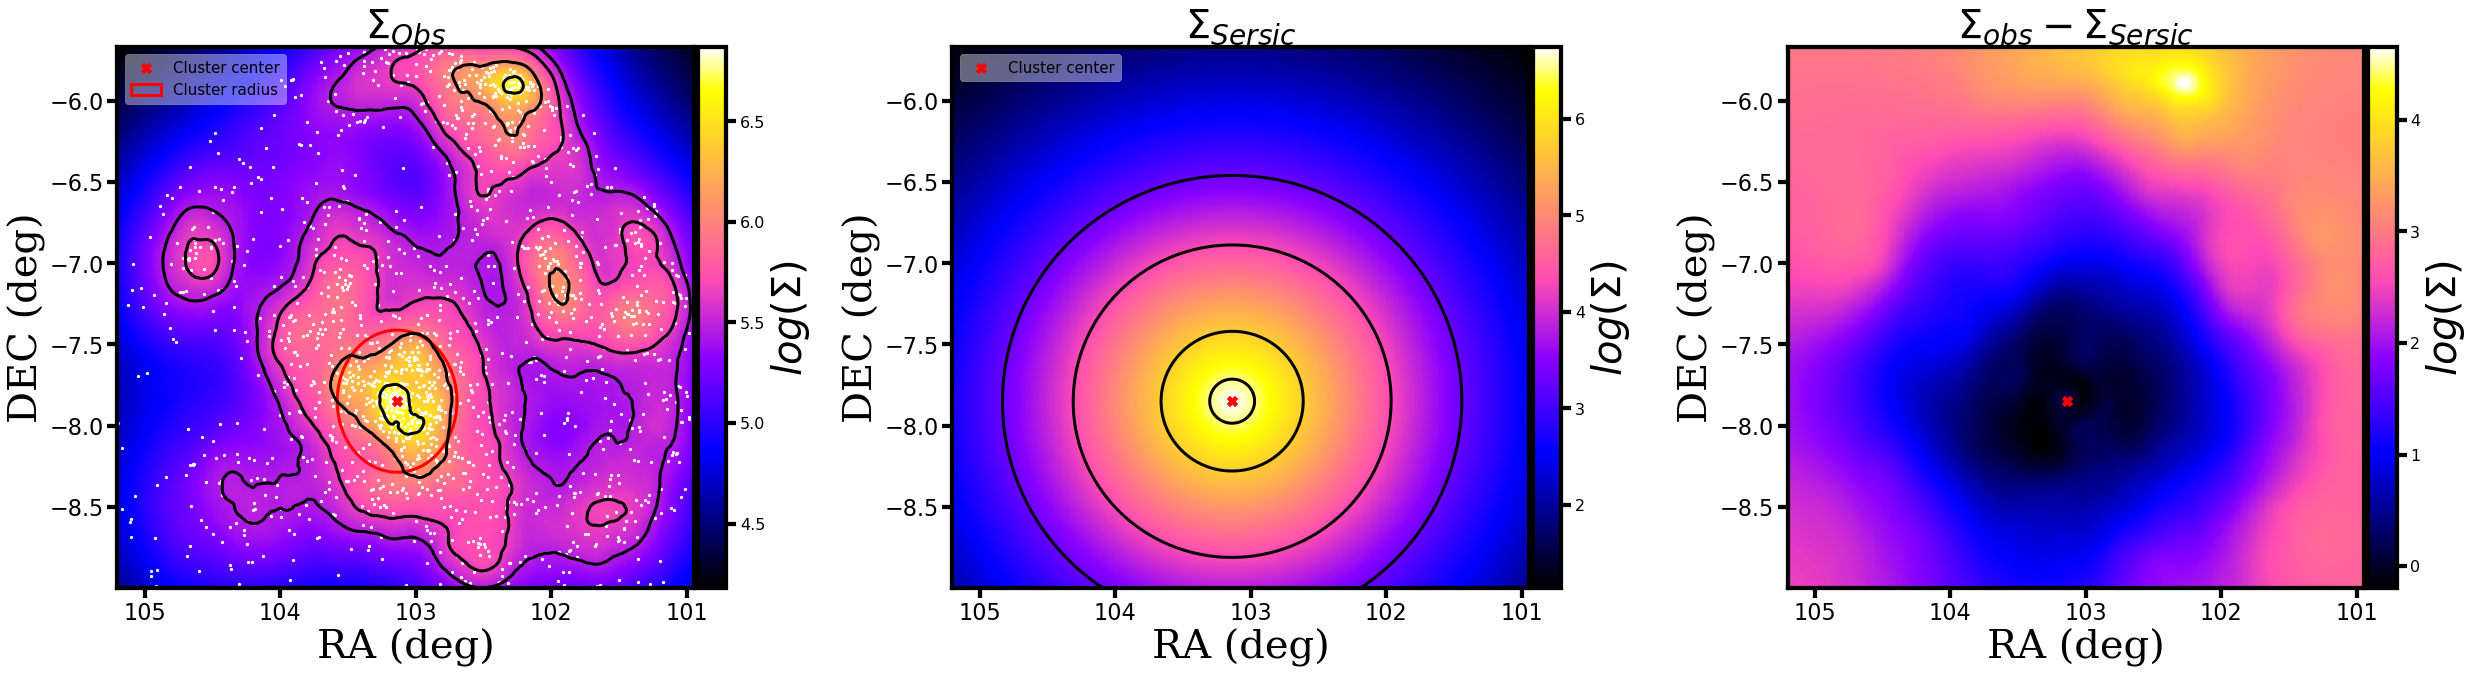

In [226]:
#Plotting the profiles to see how they look like
#Densiy maps
fig = plt.figure(figsize=(35, 10))

#=======================================
#"True" member and infalling galaxies
#=======================================

ax1 = fig.add_subplot(131)
conversion_factor = 1
sc1 = ax1.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), cmap=cm3)
ax1.scatter(x2, y2, s=5, color='white')

ax1.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), colors="black", 
            levels=np.percentile(np.log10(zz/conversion_factor), [50, 75, 95., 99.5]),
            linewidths=3.0, linestyle="solid")

ax1.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax1.set_ylabel("DEC (deg)", fontdict=font)
ax1.set_xlabel("RA (deg)", fontdict=font)

c0 = SkyCoord(ra=ra0_new, dec=dec0_new, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.invert_xaxis()
ax1.set_title(r"$\Sigma_{Obs}$", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)


#=======================================
#Galaxies selected by the method
#=======================================

ax2 = fig.add_subplot(132)
sc1 = ax2.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), Sersic_profile, cmap=cm3)

ax2.contour(np.rad2deg(xx), np.rad2deg(yy), Sersic_profile, colors="black", 
            levels=np.percentile(Sersic_profile, [50, 75, 95., 99.5]),
            linewidths=3.0, linestyle="solid")

ax2.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")
# r1 = SphericalCircle(c0, Re*u.deg, resolution=100, vertex_unit='deg', 
#             lw=3, label=r"$r_e$", edgecolor="red", facecolor="None")
# ax2.add_patch(r1)

ax2.set_ylabel("DEC (deg)", fontdict=font)
ax2.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax2.set_title(r"$\Sigma_{Sersic}$", fontdict=font)
ax2.legend(fontsize=15, loc=2, framealpha=0.4)
ax2.invert_xaxis()

#=======================================
#Galaxies selected by the method
#=======================================

ax3 = fig.add_subplot(133)
sc1 = ax3.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor) - Sersic_profile, cmap=cm3)

ax3.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax3.set_ylabel("DEC (deg)", fontdict=font)
ax3.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax3)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax3.set_title(r"$\Sigma_{obs} - \Sigma_{Sersic}$", fontdict=font)
ax3.invert_xaxis()

fig.tight_layout(pad=3.0)

Text(0.5, 1.0, '$\\Sigma_{2-halo}$')

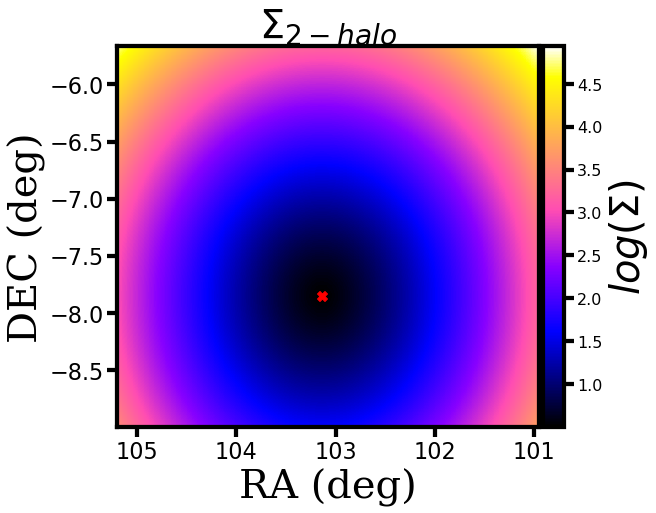

In [238]:
#Sigma_2halo from model
fig = plt.figure(figsize=(8, 7))

#=======================================
#"True" member and infalling galaxies
#=======================================

ax1 = fig.add_subplot(111)
conversion_factor = 1
sc1 = ax1.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), Sigma_2halo, cmap=cm3)

ax1.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax1.set_ylabel("DEC (deg)", fontdict=font)
ax1.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.invert_xaxis()
ax1.set_title(r"$\Sigma_{2-halo}$", fontdict=font)
# ax1.legend(fontsize=15, loc=2, framealpha=0.4)

In [256]:
#Metropolis-Hastings
def transition_model(params):
    return [np.random.normal(params[i], scale=0.05, size=(1,))[0] for i in range(len(params))]



# Likelihood function: Log of the probability of observing the data given the model
def log_likelihood(params, x, y, R, observed_density):  
    Sigma0, Re, n, Rt, tau, rho_m, r_out, gamma, q, theta = params 
    model_density = Sigma_(x, y, R, Sigma0, Re, n, Rt, tau, rho_m, r_out, gamma, q, theta)
#     Sigma0, Re, n, q, theta = params 
#     model_density = Sersic_profile_(x, y, Sigma0, Re, n, q, theta)
    residuals = observed_density - model_density
    # Assuming Gaussian noise, the log likelihood is proportional to the square of residuals
    return -0.5 * np.sum(residuals**2)



# Define prior distributions (simple uniform priors in this case)
def log_prior(params):
    Sigma0, Re, n, Rt, tau, rho_m, r_out, gamma, q, theta = params
    if 0 < q < 1 and 0 < Sigma0 and 0 < Re < 3*r200_deg and 0 < n < 1 and 0 < theta < np.pi and 0 < r_out and 1.0 < gamma and 0 < tau and 0 < Rt < 3*r200_deg:
#     Sigma0, Re, n, q, theta = params
#     if 0 < q < 1 and 0 < Sigma0 and 0 < Re and 0 < n < 1 and 0 < theta < np.pi:
        return 0.0  # log(1) = 0, uniform prior
    return -np.inf  # log(0) = -inf, to reject parameters outside these ranges



#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new > x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new - x)))


    
def metropolis_hastings(likelihood, prior, transition_model, param_init, iterations, x, y, R, data, acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    p = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        p_new =  transition_model(p)    
        p_like = likelihood(p, x, y, R, data)
        p_new_like = likelihood(p_new, x, y, R, data) 
        if (acceptance(p_like + prior(p), p_new_like + prior(p_new))):            
            p = p_new
            accepted.append(p_new + [i])
        else:
            rejected.append(p_new + [i])            
                
    return np.array(accepted), np.array(rejected)



#Initial guess for parameters
initial_params = [3.5, 1.0*r200_deg[0], 0.5, 3.0*r200_deg[0], 4.0, 1.0, 5*r200_deg[0], 1.5, 0.5, 0]  #[Sigma0, Re, n, Rt, tau, rho_m, r_out, gamma, q, theta]
# initial_params = [3.5, 1.0*r200_deg[0], 0.5, 1.0, 5*r200_deg[0], 1.5, 0.5, 0]  #[Sigma0, Re, n, rho_m, r_out, gamma, q, theta]
# initial_params = [3.5, 1.0*r200_deg, 1.0, 0.5, 0]  #[Sigma0, Re, n, rho_m, r_out, gamma, q, theta]


accepted, rejected = metropolis_hastings(
        likelihood=log_likelihood,
        prior=log_prior,
        transition_model=transition_model,
        param_init=initial_params,
        iterations=20000, 
        x=xx_centered,
        y=yy_centered, 
        R=R,
        data=np.log10(zz),
        acceptance_rule=acceptance)


print("Number of accepted samples: {}".format(len(accepted)))

/tmp/ipykernel_1870943/650849269.py:38: RuntimeWarning: invalid value encountered in double_scalars
  return (accept < (np.exp(x_new - x)))


Number of accepted samples: 47


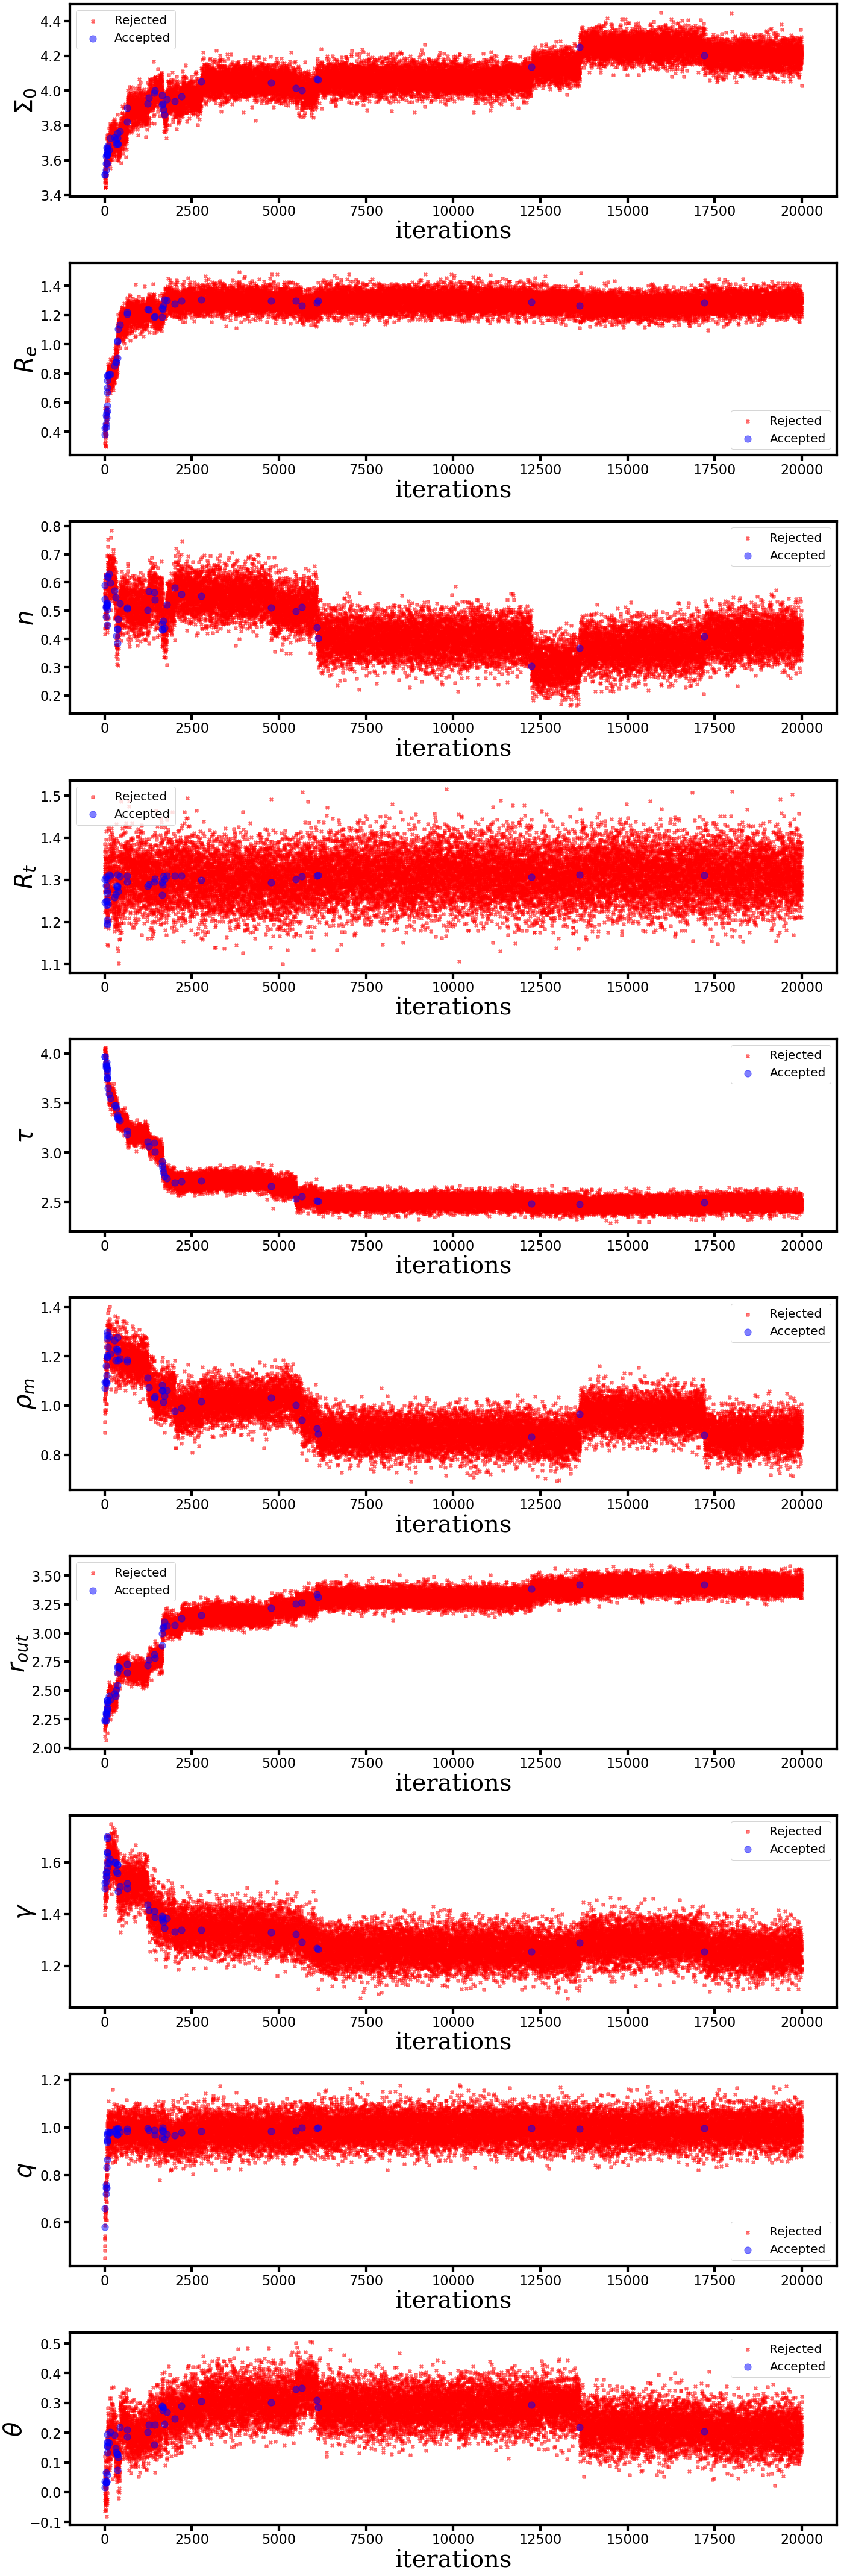

In [257]:
fig, axs = plt.subplots(10, 1, figsize=(20, 60))

for i in range(len(axs)):
    axs[i].scatter(rejected[:, -1], rejected[:, i], marker='X', color="red", label="Rejected", alpha=0.5)
    axs[i].scatter(accepted[:, -1], accepted[:, i], marker='.', color="blue", label="Accepted", alpha=0.5, s=500)
    axs[i].set_xlabel("iterations", fontdict=font)
    axs[i].legend(fontsize=20)

axs[0].set_ylabel(r'$\Sigma_0$', fontdict=font)
axs[1].set_ylabel(r'$R_e$', fontdict=font)  
axs[2].set_ylabel(r'$n$', fontdict=font) 
axs[3].set_ylabel(r'$R_t$', fontdict=font) 
axs[4].set_ylabel(r'$\tau$', fontdict=font) 
axs[5].set_ylabel(r'$\rho_m$', fontdict=font) 
axs[6].set_ylabel(r'$r_{out}$', fontdict=font) 
axs[7].set_ylabel(r'$\gamma$', fontdict=font) 
axs[8].set_ylabel(r'$q$', fontdict=font) 
axs[9].set_ylabel(r'$\theta$', fontdict=font) 


fig.tight_layout(pad=3.0)

# plt.savefig("../figures/elliptical_profiles/MH-parameters-time-series_mock{}.png".format(i_mock), dpi='figure', format='png')

In [258]:
best_fit_params = [accepted[-1, i] for i in range(len(accepted[0, :])-1)]
# Sigma = Sersic_profile_(xx_centered, yy_centered, *best_fit_params)
Sigma = Sigma_(xx_centered, yy_centered, R, *best_fit_params)
Re = best_fit_params[1]

/tmp/ipykernel_1870943/1980727871.py:13: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax1.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), colors="black",
/tmp/ipykernel_1870943/1980727871.py:46: UserWarning: The following kwargs were not used by contour: 'linestyle'
  ax2.contour(np.rad2deg(xx), np.rad2deg(yy), Sigma, colors="black",


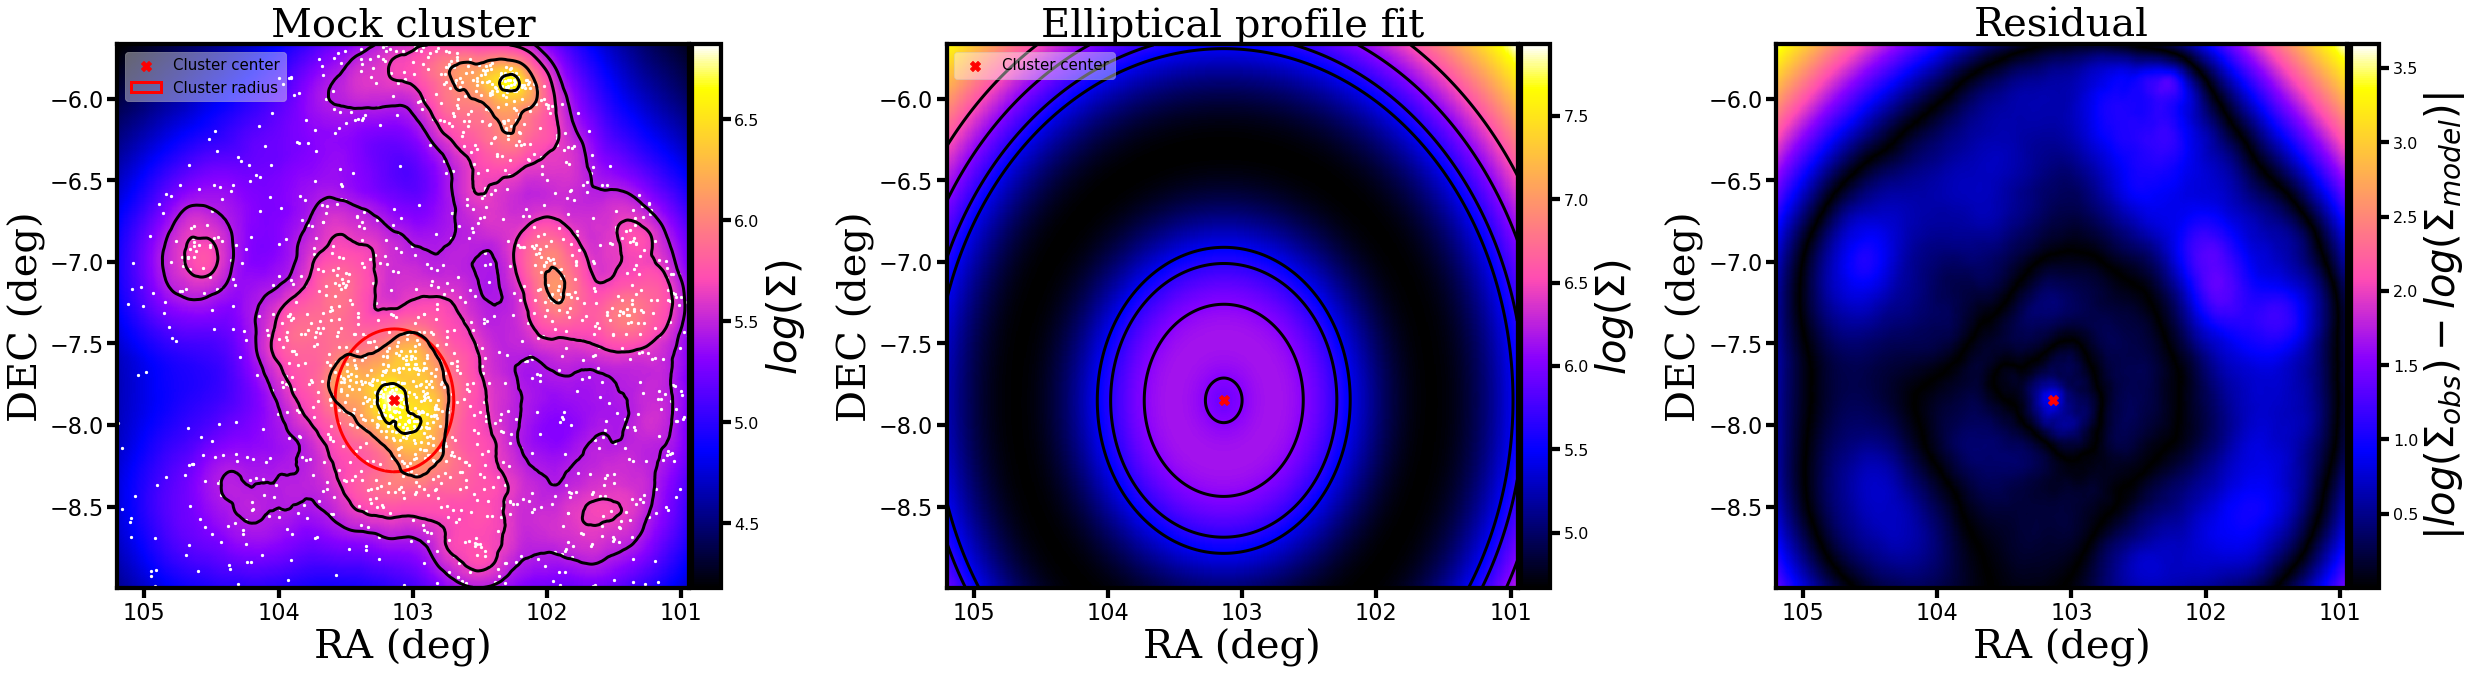

In [259]:
#Densiy maps
fig = plt.figure(figsize=(35, 10))

#=======================================
#"True" member and infalling galaxies
#=======================================

ax1 = fig.add_subplot(131)
conversion_factor = 1
sc1 = ax1.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), cmap=cm3)
ax1.scatter(x2, y2, s=5, color='white')

ax1.contour(np.rad2deg(xx), np.rad2deg(yy), np.log10(zz/conversion_factor), colors="black", 
            levels=np.percentile(np.log10(zz/conversion_factor), [50, 75, 95., 99.5]),
            linewidths=3.0, linestyle="solid")

ax1.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax1.set_ylabel("DEC (deg)", fontdict=font)
ax1.set_xlabel("RA (deg)", fontdict=font)

c0 = SkyCoord(ra=ra0_new, dec=dec0_new, frame='icrs', unit='deg')

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax1.invert_xaxis()
ax1.set_title("Mock cluster", fontdict=font)
ax1.legend(fontsize=15, loc=2, framealpha=0.4)


#=======================================
#Galaxies selected by the method
#=======================================

ax2 = fig.add_subplot(132)
sc1 = ax2.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), Sigma, cmap=cm3)

ax2.contour(np.rad2deg(xx), np.rad2deg(yy), Sigma, colors="black", 
            levels=np.percentile(np.log10(zz/conversion_factor), [50, 75, 95., 99.5]),
            linewidths=3.0, linestyle="solid")

ax2.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")
# r1 = SphericalCircle(c0, Re*u.deg, resolution=100, vertex_unit='deg', 
#             lw=3, label=r"$r_e$", edgecolor="red", facecolor="None")
# ax2.add_patch(r1)

ax2.set_ylabel("DEC (deg)", fontdict=font)
ax2.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$log(\Sigma)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax2.set_title("Elliptical profile fit", fontdict=font)
ax2.legend(fontsize=15, loc=2, framealpha=0.4)
ax2.invert_xaxis()

#=======================================
#Galaxies selected by the method
#=======================================

ax3 = fig.add_subplot(133)
sc1 = ax3.pcolormesh(np.rad2deg(xx), np.rad2deg(yy), np.abs(np.log10(zz/conversion_factor)- Sigma), cmap=cm3)

ax3.scatter(ra0_new, dec0_new, marker="X", s=100, color="red", label="Cluster center")

ax3.set_ylabel("DEC (deg)", fontdict=font)
ax3.set_xlabel("RA (deg)", fontdict=font)

divider = make_axes_locatable(ax3)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$\left\| log(\Sigma_{obs}) - log(\Sigma_{model}) \right\|$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

ax3.set_title("Residual", fontdict=font)
ax3.invert_xaxis()

fig.tight_layout(pad=3.0)

# plt.savefig("../figures/elliptical_profiles/density-profiles_mock{}.png".format(i_mock), dpi='figure', format='png')

In [ ]:
#MCMC emcee implementation

# Likelihood function: Log of the probability of observing the data given the model
def log_likelihood(params, x, y, observed_density):  
    Sigma0, bn, re, n, q, theta = params 
    model_density = Sersic_profile_(x, y, Sigma0, bn, re, n, q, theta)
    residuals = observed_density - model_density
    # Assuming Gaussian noise, the log likelihood is proportional to the square of residuals
    return -0.5 * np.sum(residuals**2)


# Define prior distributions (simple uniform priors in this case)
def log_prior(params):
    Sigma0, bn, re, n, q, theta = params
    if 0.01 < q < 1 and 0 < Sigma0 and 0 < re and 0 < n < 10 and 0 < theta < 180:
        return 0.0  # log(1) = 0, uniform prior
    return -np.inf  # log(0) = -inf, to reject parameters outside these ranges


# Full log probability function (posterior)
def log_probability(params, x, y, observed_density):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, observed_density)


# Initial guess for parameters
initial_params = [1.0, 1.0, 1.0, 1.0, 0.5, 45]  # [Sigma0, bn, re, n, q, theta]

# Set up the MCMC sampler
nwalkers = 24  # Number of walkers (chains)
ndim = len(initial_params)  # Number of parameters to estimate

pos = initial_params + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xx_centered, yy_centered, zz))
nsteps = 5000  # Number of steps for each walker
sampler.run_mcmc(pos, nsteps, progress=True)
samples = sampler.get_chain(discard=2000, thin=15, flat=True)


#========================================
#CORNER PLOT
#========================================

corner_kwargs = dict(
    label_kwargs=dict(fontsize=25, rotation=0),
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=4,
    title_fmt=".2E"
)

f = 0.6

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 3.3 * f
rcParams["xtick.minor.width"] = 3.3 * f
rcParams["ytick.major.width"] = 3.3 * f
rcParams["ytick.minor.width"] = 3.3 * f
rcParams["xtick.major.size"] = 6.5 * f
rcParams["xtick.minor.size"] = 3.5 * f
rcParams["ytick.major.size"] = 6.5 * f
rcParams["ytick.minor.size"] = 3.5 * f
rcParams["axes.labelpad"] = "0.1"

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


fig = corner.corner(samples, 
                    labels=[r"$\Sigma_0$", r"$b_n$", r"$r_e$", "n", "q", r"$\theta$"],
                   color=colors3[0],
                   **corner_kwargs)

plt.savefig("../figures/elliptical_profiles/MCMC_corner_plot_mock{}.png".format(i_mock), dpi='figure', format='png')

#========================================
#BEST FIT PARAMS
#========================================
# Median of posterior samples (best-fit parameters)
best_fit_params = np.median(samples, axis=0)
print("Best fit parameters:", best_fit_params)

#========================================
#SETTING PLOT PARAMETERS BACK TO NORMAL
#========================================
f = 0.8

rc("xtick", labelsize=fontsize * f)
rc("ytick", labelsize=fontsize * f)
rcParams["axes.linewidth"] = 5.3 * f
rcParams["xtick.major.width"] = 5.3 * f
rcParams["xtick.minor.width"] = 5.3 * f
rcParams["ytick.major.width"] = 5.3 * f
rcParams["ytick.minor.width"] = 5.3 * f
rcParams["xtick.major.size"] = 12.5 * f
rcParams["xtick.minor.size"] = 6.5 * f
rcParams["ytick.major.size"] = 12.5 * f
rcParams["ytick.minor.size"] = 6.5 * f

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 50 * f,
        }


fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
labels = [r"$\Sigma_0$", r"$b_n$", r"$r_e$", "n", "q", r"$\theta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontdict=font)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontdict=font)

plt.savefig("../figures/elliptical_profiles/MCMC_params_evolution_mock{}.png".format(i_mock), dpi='figure', format='png')

In [34]:
completeness_ell = []
purity_ell = []

Sigma_lim_arr = np.linspace(np.log10(Sersic_profile).min(), np.log10(Sersic_profile).max()-0.5, 100)

for Sigma_lim in Sigma_lim_arr:
    
#     mask_inside_Sigma_lim = np.array([np.log10(zz[np.argmin(np.abs(x[i] - xx.T[0])), np.argmin(np.abs(y[i] - yy[0]))]) 
#                                                > Sigma_lim for i in range(len(x))])

    mask_inside_Sigma_lim = np.array([np.log10(Sersic_profile[np.argmin(np.abs(x[i] - xx.T[0])), np.argmin(np.abs(y[i] - yy[0]))]) 
                                               > Sigma_lim for i in range(len(x))])
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster_unbiased][P_pz_C_array > cut_zp][mask_2r200][mask_inside_Sigma_lim])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster_unbiased][P_pz_C_array > cut_zp][mask_2r200][mask_inside_Sigma_lim],
                       galaxyId[halo_mask])) / len(galaxyId[mask_cluster_unbiased][P_pz_C_array > cut_zp][mask_2r200][mask_inside_Sigma_lim])
    
    completeness_ell.append(c)
    purity_ell.append(p)
    
    
completeness_ell = np.array(completeness_ell)
purity_ell = np.array(purity_ell)
F1_ell = 2 * completeness_ell*purity_ell/(completeness_ell + purity_ell)

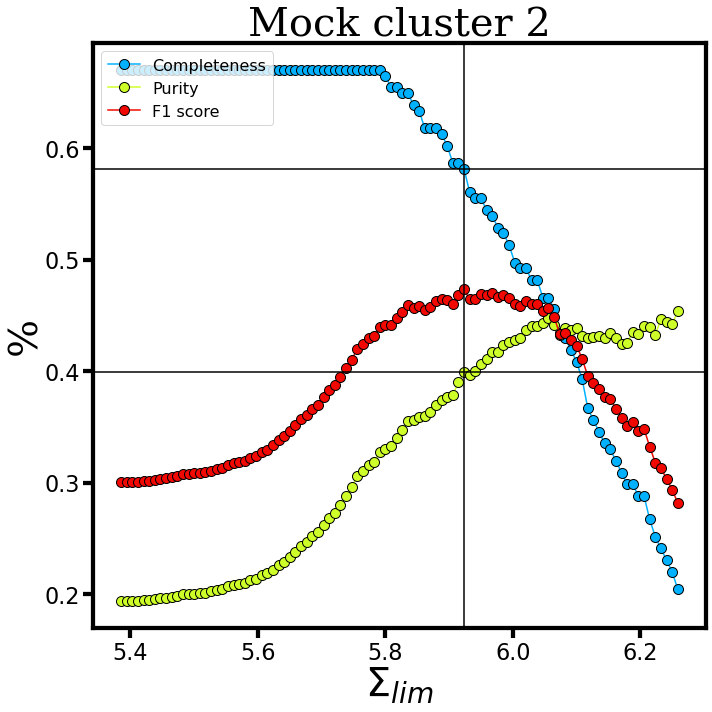

In [35]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Sigma_lim_arr, completeness_ell, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Sigma_lim_arr, purity_ell, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Sigma_lim_arr, F1_ell, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel(r"$\Sigma_{lim}$", fontdict=font)

ax1.axvline(Sigma_lim_arr[np.argmax(F1_ell[~np.isnan(F1_ell)])], color="black")
ax1.axhline(purity_ell[np.argmax(F1_ell[~np.isnan(F1_ell)])], color="black")
ax1.axhline(completeness_ell[np.argmax(F1_ell[~np.isnan(F1_ell)])], color="black")

ax1.legend(fontsize=labelsize, loc=2)

fig.tight_layout()

plt.savefig("../figures/elliptical_profiles/purity_completeness_ellipses_mock{}.png".format(i_mock), dpi='figure', format='png')

### Compute P(C | R)

In [32]:
#To go to the radial probabilities, we have to define a cut in P(C | zp), computed above
mask_cluster_zp = (P_pz_C_array > cut_zp)

def radial_fit():
    no_radial_fit = False
    frr = 5
    while frr > 0:
        try:
            mask_cluster_R = (dist[mask_cluster_unbiased] < frr*r200_deg) & mask_cluster_zp
            Pmem_R_C, Pmem_R_F, w1, w2, alpha = radial_mem_prob(dist[mask_cluster_unbiased][mask_cluster_R], rc=r200_deg, name=i_mock, fz=fz2, cluster_profile="power-law", plot=True)
            return Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit
        except RuntimeError:
            frr -= 0.5
            if frr == 0:
                print(f"Fit attempt with frr={frr} failed. It seems this cluster cannot be fitted with the given profile.")
                no_radial_fit = True

                Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R = [np.nan] * 6
                return Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit

            else:
                pass

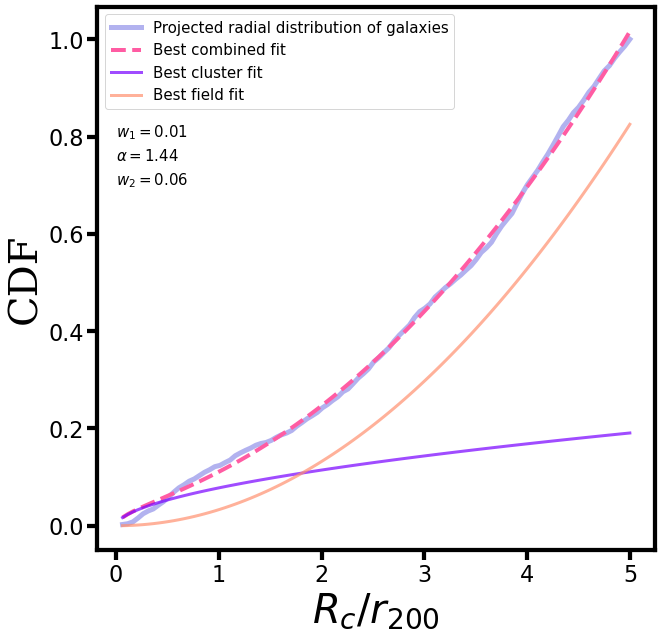

In [33]:
Pmem_R_C, Pmem_R_F, w1, w2, alpha, mask_cluster_R, no_radial_fit = radial_fit()

In [203]:
completeness_R = []
purity_R = []
d = 0.01
Pmem_cut_arr_R = np.arange(0.0, 1.0, d)

for Pmem_cut in Pmem_cut_arr_R:
    
    c = np.sum(np.isin(galaxyId[halo_mask], galaxyId[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > Pmem_cut])) / len(galaxyId[halo_mask])
    p = np.sum(np.isin(galaxyId[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > Pmem_cut], galaxyId[halo_mask])) / len(galaxyId[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > Pmem_cut])
    
    completeness_R.append(c)
    purity_R.append(p)

In [204]:
#We need a criterium to determine a cut P(C | zp) > p0. One way is by optimizing the F1 score, defined below.
completeness_R = np.array(completeness_R)
purity_R = np.array(purity_R)

F1_R = 2 * completeness_R*purity_R/(completeness_R + purity_R)

cut_R = Pmem_cut_arr_R[np.argmax(F1_R[~np.isnan(F1_R)])]

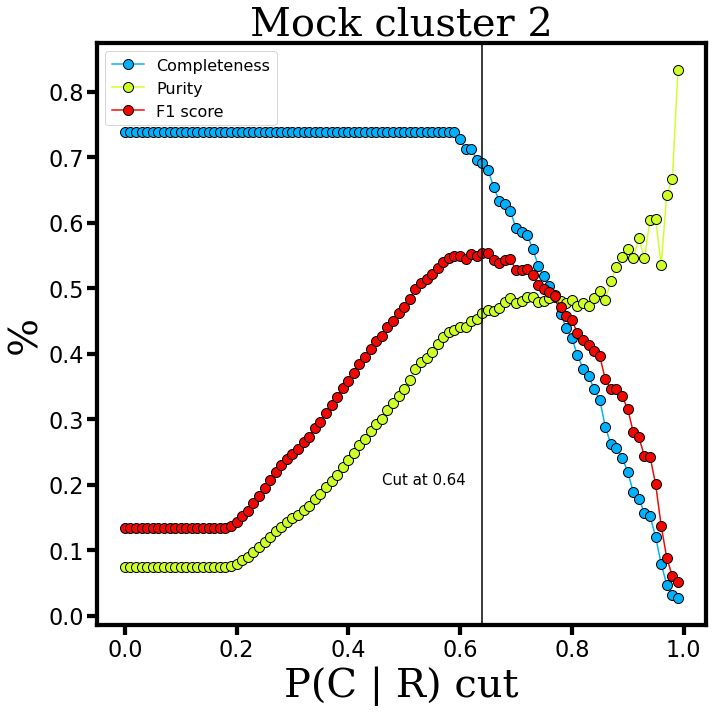

In [205]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ms = 10
ax1.plot(Pmem_cut_arr_R, completeness_R, marker='o', color=colors1[2],
         label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, purity_R, marker='o', color=colors1[5], 
         label="Purity", markersize=ms, markeredgecolor="black")
ax1.plot(Pmem_cut_arr_R, F1_R, marker='o', color=colors1[8], 
         label="F1 score", markersize=ms, markeredgecolor="black")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_ylabel("%", fontdict=font)
ax1.set_xlabel("P(C | R) cut", fontdict=font)

ax1.axvline(cut_R, color="black")
ax1.text(x=cut_R-0.18, y=0.2, s="Cut at {:.2f}".format(cut_R), fontsize=15)

# c_best = 0.56
# ax1.axhline(c_best, color="black", linestyle="dashed")
# ax1.text(0.2, y=c_best+0.01, s="{:.2f}".format(c_best), fontsize=15)

# p_best = 0.56
# ax1.axhline(p_best, color="black", linestyle="dashed")
# ax1.text(0.2, y=p_best+0.01, s="{:.2f}".format(p_best), fontsize=15)


ax1.legend(fontsize=labelsize, loc=2)

fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/purity_completeness_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

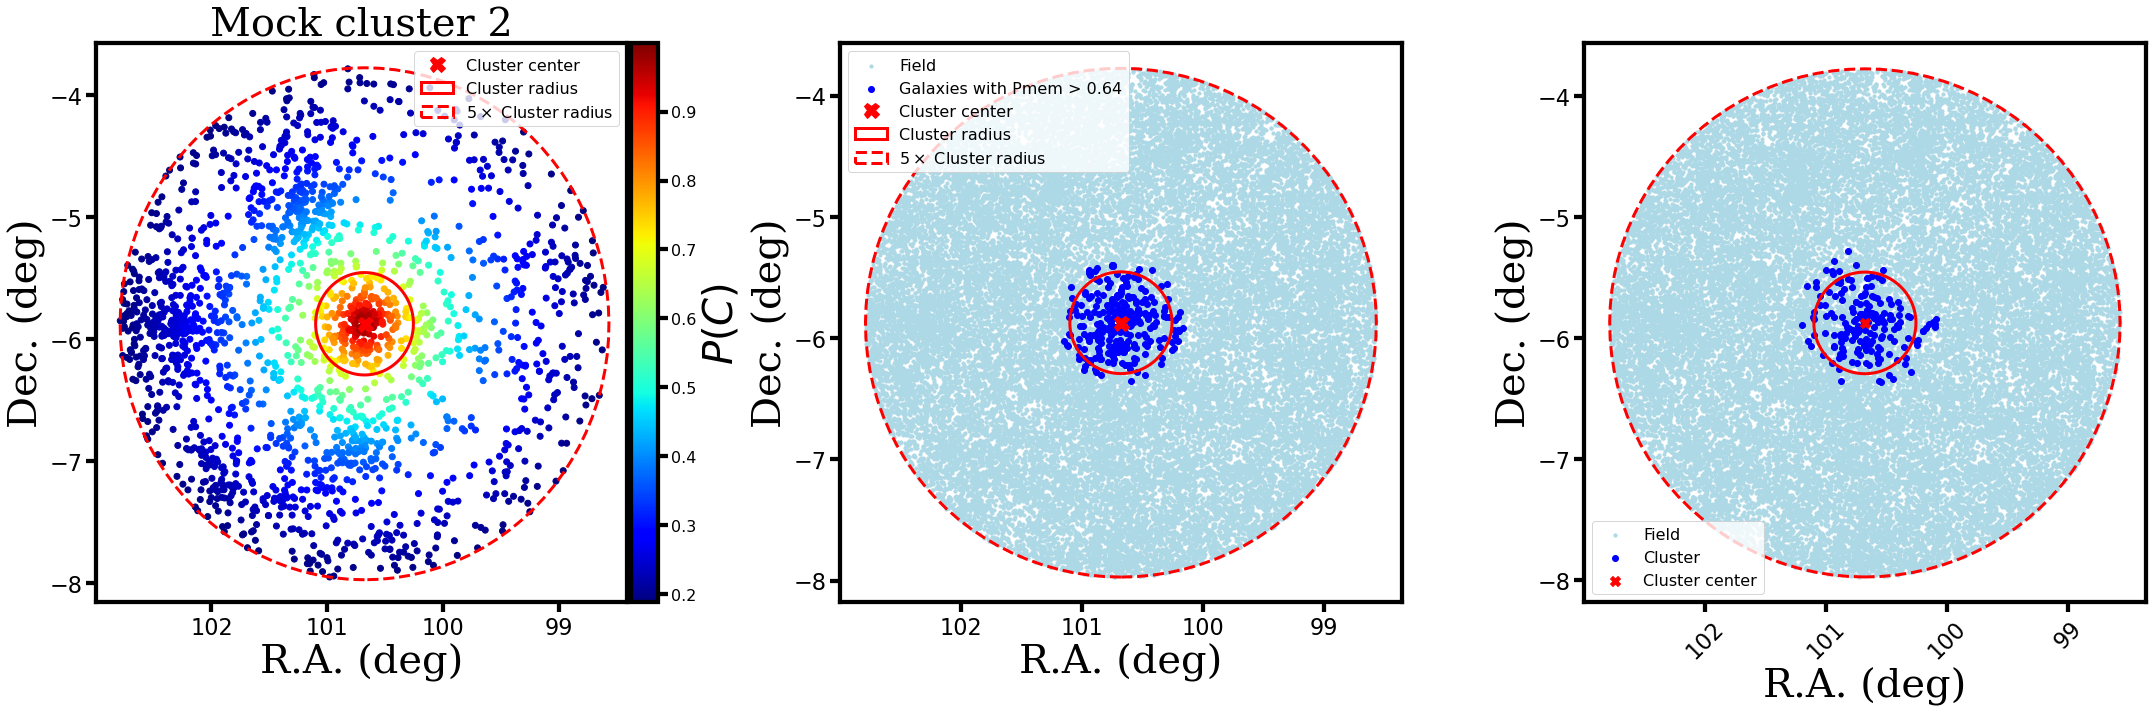

In [206]:
fig = plt.figure(figsize=(30, 10))


ax1 = fig.add_subplot(131)
sc1 = ax1.scatter(ra[mask_cluster_unbiased][mask_cluster_R], dec[mask_cluster_unbiased][mask_cluster_R], 
                  marker='o', c=Pmem_R_C, cmap="jet", rasterized=True)
ax1.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.invert_xaxis()
# ax1.set_title(cl_names[cluster], fontdict=font)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc1, cax=cax1, orientation='vertical')
cbar.set_label(label=r"$P(C)$", fontdict=font)
cbar.ax.tick_params(labelsize=labelsize)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)

r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r5)
ax1.legend(fontsize=labelsize)



ax2 = fig.add_subplot(132)
ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], c="lightblue", s=10, label="Field")
sc2 = ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], dec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R],
                  marker='o', c="blue", rasterized=True, label="Galaxies with Pmem > {:.2f}".format(cut_R))
ax2.plot(ra0, dec0, 'X', color="red", markersize=15, label="Cluster center")
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.invert_xaxis()

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax2.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r5)
ax2.legend(fontsize=labelsize)



ax3 = fig.add_subplot(133)
ax3.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                c="lightblue", s=10, label="Field")
ax3.scatter(halo_ra, halo_dec, c="blue", label="Cluster")
ax3.set_xlabel("R.A. (deg)", fontdict=font)
ax3.set_ylabel("Dec. (deg)", fontdict=font)
ax3.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax3.legend(fontsize=labelsize)
ax3.tick_params(axis='x', rotation=45)

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax3.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax3.add_patch(r5)
ax3.invert_xaxis()


fig.tight_layout(pad=3.0)
 
fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_separation_P(C|R)_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

### Unifying potentially infalling galaxies with potential member galaxies on the same plot:

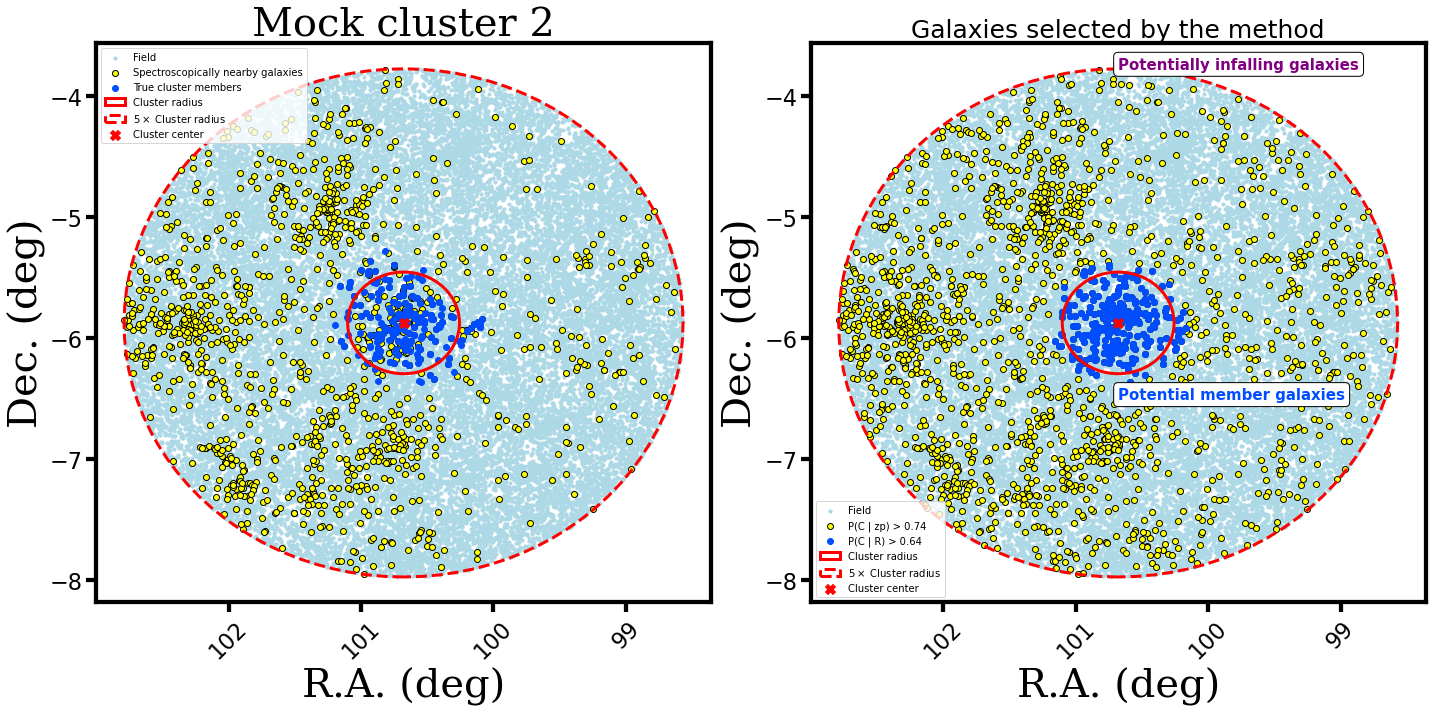

In [207]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                color="lightblue", s=10, label="Field")
ax1.scatter(ra[mask_cluster_unbiased][mask_infalling], dec[mask_cluster_unbiased][mask_infalling], color="yellow", label="Spectroscopically nearby galaxies", edgecolor="k")
ax1.scatter(halo_ra, halo_dec, color=colors1[1], label="True cluster members")


r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax1.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax1.add_patch(r5)
ax1.invert_xaxis()

ax1.set_title("Mock cluster {:d}".format(i_mock), fontdict=font)
# ax1.set_title("'Ideal' scenario", fontsize=25)
ax1.set_xlabel("R.A. (deg)", fontdict=font)
ax1.set_ylabel("Dec. (deg)", fontdict=font)
ax1.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax1.legend(fontsize=10)
ax1.tick_params(axis='x', rotation=45)




ax2.scatter(ra[~halo_mask][dist_field < max_dist], dec[~halo_mask][dist_field < max_dist], 
                color="lightblue", s=10, label="Field")
ax2.scatter(ra[mask_cluster_unbiased][P_pz_C_array > cut_zp], dec[mask_cluster_unbiased][P_pz_C_array > cut_zp], color="yellow", 
                label="P(C | zp) > {:.2f}".format(cut_zp), edgecolor="k")
sc2 = ax2.scatter(ra[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R], dec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R],
                  marker='o', color=colors1[1], rasterized=True, label="P(C | R) > {:.2f}".format(cut_R))


ax2.text(ra0, dec0+5*r200_deg, s="Potentially infalling galaxies", fontsize=15, color="purple", bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")
ax2.text(ra0, dec0-1.5*r200_deg, s="Potential member galaxies", fontsize=15, color=colors1[1], bbox=dict(boxstyle="round", ec="k",
                   fc="white"), fontweight="bold")

r1 = SphericalCircle(c0, r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label="Cluster radius", edgecolor="red", facecolor="None")
ax2.add_patch(r1)
r5 = SphericalCircle(c0, 5*r200_deg*u.deg, resolution=100, vertex_unit='deg', 
            lw=3, label=r"$5 \times$ Cluster radius", edgecolor="red", facecolor="None", ls='--')
ax2.add_patch(r5)


ax2.set_title("Galaxies selected by the method", fontsize=25)
ax2.set_xlabel("R.A. (deg)", fontdict=font)
ax2.set_ylabel("Dec. (deg)", fontdict=font)
ax2.scatter(ra0, dec0, marker="X", s=100, color="red", label="Cluster center")
ax2.tick_params(axis='x', rotation=45)
ax2.invert_xaxis()
ax2.legend(fontsize=10, loc=3)

    
fig.tight_layout(pad=3.0)

fig.tight_layout()

# plt.savefig("../figures/membership-testing-on-mocks/cluster_field_sepration_final_(KNN-with-z)_fz{}_mock{}.png".format(fz2, i_mock), dpi='figure', format='png')

### Additional plots

/tmp/ipykernel_12177/791109110.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout(pad=4.0)
/tmp/ipykernel_12177/791109110.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/home/elismar/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


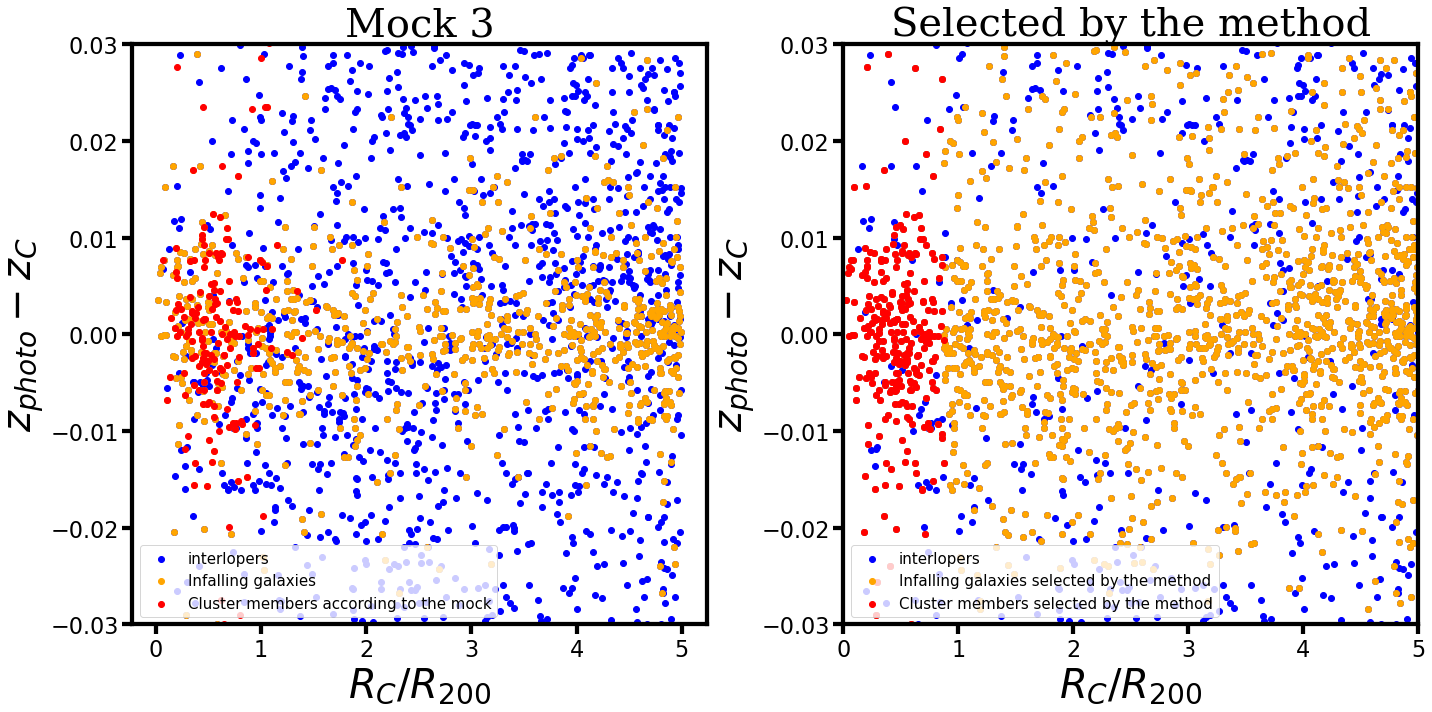

In [149]:
mask_zphot = (z_phot_pdfs_unbiased[~halo_mask] > z_cluster - 0.03) & (z_phot_pdfs_unbiased[~halo_mask] < z_cluster + 0.03) & (dist[~halo_mask] < 5*r200_deg)
zphot_interlopers = z_phot_pdfs_unbiased[~halo_mask][mask_zphot]

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(dist[~halo_mask][mask_zphot]/r200_deg, zphot_interlopers - z_cluster, color="blue", label="interlopers")
ax1.scatter(dist[mask_cluster_unbiased][mask_infalling]/r200_deg, z_phot_pdfs_unbiased[mask_cluster_unbiased][mask_infalling] - z_cluster, color="orange", label="Infalling galaxies")
ax1.scatter(dist[halo_mask]/r200_deg, halo_zphot - z_cluster, color="red", label="Cluster members according to the mock")
ax1.set_ylim(-0.03, 0.03)
ax1.set_ylabel(r"$z_{photo} - z_C$", fontdict=font)
ax1.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax1.set_title("Mock {}".format(i_mock), fontdict=font)
ax1.legend(fontsize=15)


ax2.scatter(dist/r200_deg, z_phot_pdfs_unbiased - z_cluster, color="blue", label="interlopers")
ax2.scatter(dist[mask_cluster_unbiased][P_pz_C_array > cut_zp]/r200_deg, z_phot_pdfs_unbiased[mask_cluster_unbiased][P_pz_C_array > cut_zp] - z_cluster, color="orange", 
            label="Infalling galaxies selected by the method")
ax2.scatter(dist[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R]/r200_deg, z_phot_pdfs_unbiased[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R] - z_cluster, 
            color="red", label="Cluster members selected by the method")
ax2.set_ylim(-0.03, 0.03)
ax2.set_xlim(0, 5)
ax2.set_ylabel(r"$z_{photo} - z_C$", fontdict=font)
ax2.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax2.set_title("Selected by the method", fontdict=font)
ax2.legend(fontsize=15)

fig.tight_layout(pad=4.0)
fig.tight_layout()

/tmp/ipykernel_12177/2328453083.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout(pad=4.0)
/tmp/ipykernel_12177/2328453083.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/home/elismar/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


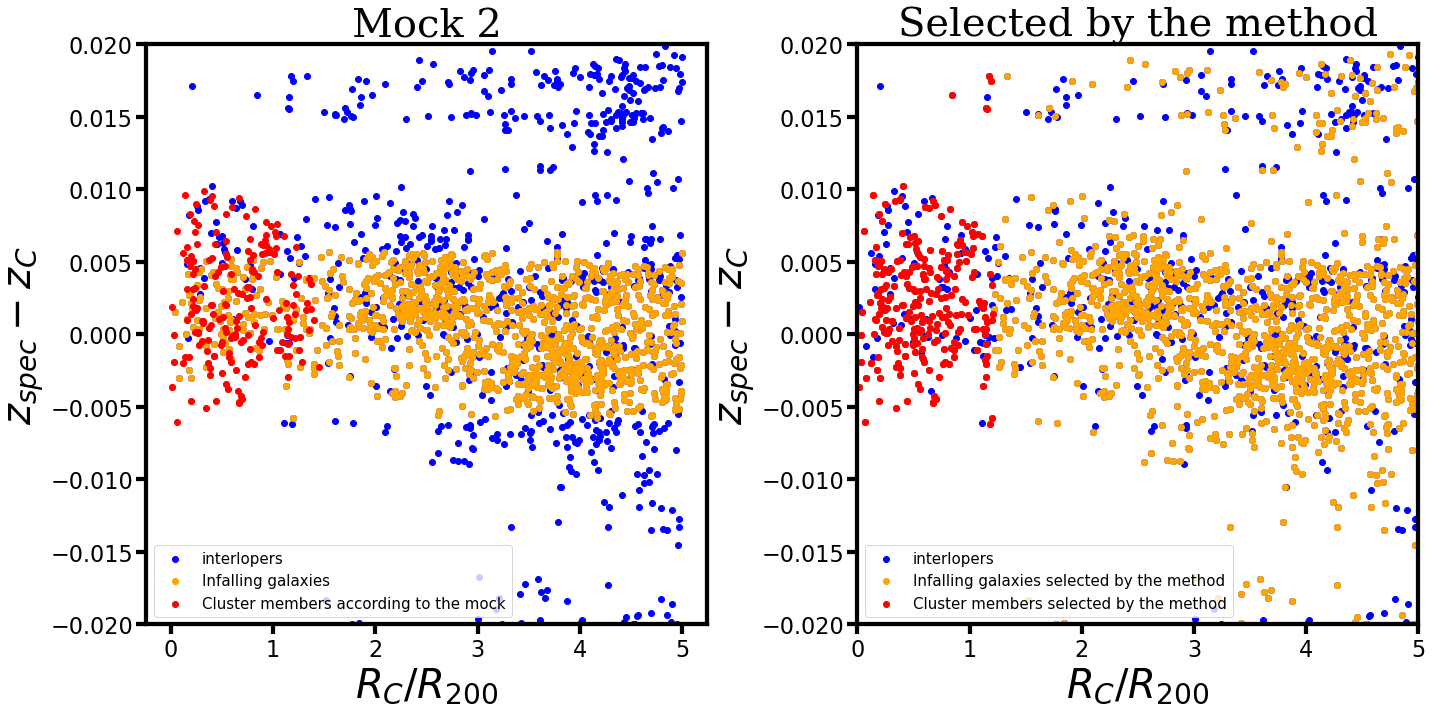

In [208]:
mask_zspec = (z_spec[~halo_mask] > z_cluster - 0.02) & (z_spec[~halo_mask] < z_cluster + 0.02) & (dist[~halo_mask] < 5*r200_deg)
zspec_interlopers = z_spec[~halo_mask][mask_zspec]

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(dist[~halo_mask][mask_zspec]/r200_deg, zspec_interlopers - z_cluster, color="blue", label="interlopers")
ax1.scatter(dist[mask_cluster_unbiased][mask_infalling]/r200_deg, z_spec[mask_cluster_unbiased][mask_infalling] - z_cluster, color="orange", label="Infalling galaxies")
ax1.scatter(dist[halo_mask]/r200_deg, halo_zspec - z_cluster, color="red", label="Cluster members according to the mock")
ax1.set_ylim(-0.02, 0.02)
ax1.set_ylabel(r"$z_{spec} - z_C$", fontdict=font)
ax1.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax1.set_title("Mock {}".format(i_mock), fontdict=font)
ax1.legend(fontsize=15)


ax2.scatter(dist/r200_deg, z_spec - z_cluster, color="blue", label="interlopers")
ax2.scatter(dist[mask_cluster_unbiased][P_pz_C_array > cut_zp]/r200_deg, z_spec[mask_cluster_unbiased][P_pz_C_array > cut_zp] - z_cluster, color="orange", 
            label="Infalling galaxies selected by the method")
ax2.scatter(dist[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R]/r200_deg, z_spec[mask_cluster_unbiased][mask_cluster_R][Pmem_R_C > cut_R] - z_cluster, 
            color="red", label="Cluster members selected by the method")
ax2.set_ylim(-0.02, 0.02)
ax2.set_xlim(0, 5)
ax2.set_ylabel(r"$z_{spec} - z_C$", fontdict=font)
ax2.set_xlabel(r"$R_C/R_{200}$", fontdict=font)
ax2.set_title("Selected by the method", fontdict=font)
ax2.legend(fontsize=15)

fig.tight_layout(pad=4.0)
fig.tight_layout()